# Analyzing Computer Science versus Business Management Introductory Course Professors Reviews and Their Trends Over Time

William Ingold, Erik Kelemen, Ashish Manda

## Introduction

This project conducts a comprehensive analysis of the perceptions, grades, and reviews of computer science and business management undergraduate students at the University of Maryland, College Park. To achieve these means, we applied various data scraping, data processing, machine learning, and data visualization and analysis techniques we learned throughout the semester, and hope to demonstrate a deep understanding of data science techniques and the data science lifecycle. We also employed natural language processing and statistical analysis to draw conclusions and answer key questions. We will illustrate the major trends in student perception of core classes and professors (how favorable certain professors are, or how hard a class may be), and we will draw generalized conclusions about the trends we observe over time (is a major getting easier? more likable?). 

### Motivation

This project was sparked by interest in a question that all undergraduate students, at one point or another, face: How do my peers experience the core courses that all prospective students in my major are required to take? We hope that, by aggregating and conducting analysis of reviews and data available on major course-review websites such as PlanetTerp and RateMyProfessor, we would be able to grasp a data informed perspective to answer this question. Erik, one of the group members, is also a dual degree undergraduate student, enrolled in both the Computer Science and Business schools at UMD, and was interested in comparing student perceptions between these two majors.

### Github

[Our GitHub Repository can be found here.](https://github.com/wingold-student/cmsc320-final-tutorial)

Clone our repository for access to all the necessary drivers and databases.

## [Table of Contents](#Table-of-Contents)
[Setup](#Setup) 

[Data Storage: Setup Storage for Reviews and Professors](#Data-Storage:-Setup-Databases-to-Hold-Review-Data)
* [Part 1: Generic Database Functionality](#Data-Storage-Part-1:-Generic-Database-Functionality)
* [Part 2: RateMyProfessor Functionality](#Data-Storage-Part-2:-RateMyProfessor-Specific-Database-Functionality)
* [Part 3: PlanetTerp Functionality](#Data-Storage-Part-3:-PlanetTerp-Database-Functionality)

[Data Collection: Getting Reviews and Professor Data](#Data-Collection-Part-1:-Grabbing-Introductory-Course-Professors-From-UMD.io)
* [Part 1: Introductory Course Professors](#Data-Collection-Part-1:-Grabbing-Introductory-Course-Professors-From-UMD.io) 
* [Part 2: Scrape and Parse RateMyProfessor](#Data-Collection-Part-2:Grabbing-Reviews-From-RateMyProfessors)
    * [CMSC RateMyProfessor Data](#Data-Collection-Part-2.8:-Scrape-and-Parse-All-Computer-Science-Professors-from-RateMyProfessor)
    * [BMGT RateMyProfessor Data](#Data-Collection-Part-2.9:-Scrape-and-Parse-All-Business-Management-Professors-from-RateMyProfessor)
* [Part 3: Query PlanetTerp API](#Data-Collection-Part-3:-Query-and-Parse-Data-from-PlanetTerp)
    * [CMSC PlanetTerp Data](#Data-Collection-Part-3.4:-Parse-All-Computer-Science-Professors-from-PlanetTerp)
    * [BMGT PlanetTerp Data](#Data-Collection-Part-3.5:-Parse-All-Business-Management-Professors-from-PlanetTerp)

[Data Aggregation](#Data-Aggregation:-Putting-It-All-Together)
 
[Analysis](#Analysis)

[Applying Machine Learning](#Applying-Machine-Learning)

[Insights and Conclusion](#Insights-and-Conclusion)

[Potential Future Work](#Potential-Future-Work)

## [Setup](#Setup)

### Technology Used

Python Libraries
* [Pandas](https://pandas.pydata.org/)
* [Numpy](https://numpy.org/)
* [Seaborn](https://seaborn.pydata.org/)
* [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [Selenium](https://www.selenium.dev/)
* [SQLite3](https://docs.python.org/3/library/sqlite3.html#module-sqlite3)
* [spaCy](https://spacy.io/)
* [Sci-Kit Learn](https://scikit-learn.org/stable/)

Useful tools
* [DB Browser for SQL](https://sqlitebrowser.org/) to view databases
* [Postman](https://www.postman.com/downloads/) to interact with RESTful API's

### Note about Selenium

RateMyProfessor requires JavaScript in order to parse the reviews of a professor.
This is because the site utilizes a "Load More" button which is powered by
JavaScript. To this end, we've utilized Selenium to load a browser and interact
with RateMyProfessor for us, in order to 'click' the "Load More" button and scrape
the appropriate review data.

[Selenium](https://www.selenium.dev/) relies upon a local browser to operate. We have included drivers for
Firefox v83.0 (x64), Microsoft Edge v87.0.664.60(x64), and Chrome v87.0.4280.88(x64). 
Here are the approriate file locations for them in our repository:
* Firefox: `'./bin/geckodriver.exe'`
* Edge: `'./bin/msedgedriver.exe'`
* Chrome: `'./bin/chromedriver.exe'`

For more information see the links below, especially if you need a different
driver version or driver type:
* https://selenium-python.readthedocs.io/installation.html
* https://github.com/mozilla/geckodriver/releases/
* https://developer.microsoft.com/en-us/microsoft-edge/tools/webdriver/
* https://chromedriver.chromium.org/downloads

If you wish to rely purely on our databases, which have already scraped
and parsed the data, you can simply set the following boolean 
should_scrape_rmp to False

In [ ]:
# Determines if we should use Scrape RMP (won't rely upon database for data if True)
should_scrape_rmp = False

# Query PlanetTerp API (won't rely upon database for data if True)
should_query_pt = False

# Determines which Selenium driver to use
use_firefox_driver = True
use_chrome_driver  = False
use_edge_driver    = False

# Determine if we should utilize data storage
should_store_data = True

In [522]:
# Querying and requests of pages
import requests

# Parsing and handling HTML elements
from bs4 import BeautifulSoup

# Storage and manipulation of data
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

# Used to check for the existance of files
from os import path

# Utilities
from itertools import chain
import collections
import re
import uuid

# Database and data storage
import pickle
import csv
import sqlite3
from sqlite3 import Error

# Selenium lets us load pages more natively, and can interact with the page
# NOTE: You must have Selenium downloaded in order to scrape RateMyProfessor
# This means having Chrome, Firefox, or any other browser supported downloaded
# and installed. It also requires a driver to be downloaded.
# SEE: https://www.selenium.dev/documentation/en/selenium_installation/installing_webdriver_binaries/
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from msedge.selenium_tools import EdgeOptions

# For handling the time & dates for reviews
import time
import datetime
import calendar

# Handling errors in try blocks
import traceback

# Graphs and Visualization
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Notebook Display and Utility
from IPython.display import Image
from IPython.display import Markdown

# TODO: Keep NLTK?
# NlTK Libraries
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

## Only need to be run once
# nltk.download('stopwords')
# nltk.download('wordnet')

# SpaCy
## If using conda, do conda install -c conda-forge spacy
import spacy
import string # for punctuation list

# For ML 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

## [Data Storage: Setup Databases to Hold Review Data](#Data-Storage:-Setup-Databases-to-Hold-Review-Data)

We have created two separate database systems for RateMyProfessors and PlanetTerp accordingly to hold data scraped from both of these sites. Additionally, we have separated CMSC and BMGT data - so we have a total of 4 databases. We have generic database functionality such as checking if all the data has been scraped for a certain professor. We can also retrieve important characteristics including professor stats, reviews and course grades through pandas dataframes. In addition, based on these characteristics, we can also insert and retrieve review sentiments for each professor. In the RateMyProfessors database, we created tables to store data for professor statistics, reviews, review tags, and professor tags. In the PlanetTerp database, we created tables to store data for statistics, reviews, and grades.

We used [SQLite3](https://www.sqlite.org/index.html) with Python for the storage. Since the data scraped from RateMyProfessor and PlanetTerp was relatively small, this offered a nice solution. Additionally, it made data storage easier to manage, since it was all local to our development. The separation was done preemptively to make the databases even more small and managable, along with just to keep a separation of data. However, choosing to only use one or two databases is perfectly fine as well, just not the route we opted for in this tutorial. Tutorials for SQLite in Python [can be found here](https://www.sqlitetutorial.net/sqlite-python/), if you want further information.

We also recommend the use of [DB Browser for SQLite](https://sqlitebrowser.org/) for browsing the database data. This can be a more managable way to view the data, then simply printing out Pandas DataFrames. This was utilized rather often in this tutorial.

If for some reason you do not wish to write or read from a database, the appropriate booleans are above to allow you to disable this. However, it is recommended you rely upon the databases, unless you want to scrape newer data or wish to experiment with the scraping, parsing and querying yourself.

### [Data Storage Part 1: Generic Database Functionality](#Data-Storage-Part-1:-Generic-Database-Functionality)

This section lays out generic database functionality, such as connecting to the database or executing SQL commands or queries. Additionally, it has functionality that works for all of our databases, regardless of it is for RateMyProfessor or PlanetTerp and for CMSC or BMGT. Functions that interact specifically RateMyProfessor and PlanetTerp are written in the following sections. We do this to keep functionality more separated and clean.

In [ ]:
# Setup database presets
db_filepath = './data/db/'
bmgt_rmp_db_filepath = db_filepath + 'bmgt_rmp.db'
cmsc_rmp_db_filepath = db_filepath + 'cmsc_rmp.db'

bmgt_pt_db_filepath = db_filepath + 'bmgt_pt.db'
cmsc_pt_db_filepath = db_filepath + 'cmsc_pt.db'

In [ ]:
def create_connection(db_file):
    """Create a connection to the provided database file.
    
    Args:
        db_file: A string holding the filepath to a database.
    """
    
    conn = None
    
    if should_store_data:
        try:
            conn = sqlite3.connect(db_file)
            return conn
        except Error as e:
            print(e)

    return conn


def execute_create_command(conn, sql_command, params=()):
    """Executes the provided sql_command on the provided database.
    
    Args:
        conn: The connection object to the database.
        sql_command: A string containing the SQL command.
        params: A tuple of potential parameters.
    """
    
    try:
        c = conn.cursor()
        c.execute(sql_command, params)
        
    except Error as e:
        print(e)
    
    
def execute_insert_command(conn, table_name, column_list, params=()):
    """Executes the provided sql_command on the provided database.
    
    Args:
        conn: The connection object to the database.
        sql_command: A string containing the SQL command.
        params: A tuple of potential parameters.
    """
    
    # Question mark for each value to be filled, don't want a trailing comma
    question_marks = "?," * (len(column_list) - 1)
    question_marks = question_marks + "?"
    
    column_names = ",".join(column_list)
    
    insert_sql = """INSERT INTO {table_name} (
                                {column_names}
                           )
                           VALUES({question_marks})
                           """.format(table_name=table_name, 
                                      question_marks=question_marks,
                                      column_names=column_names)
    
    try:
        c = conn.cursor()
        c.execute(insert_sql, params)
        conn.commit()
        
        return c.lastrowid
    except Error as e:
        print(e)
        
        
def execute_query_command(conn, sql_command, params=()):
    """Executes the provided sql_command on the provided database.
    
    Args:
        conn: The connection object to the database.
        sql_command: A string containing the SQL command.
        params: A tuple of potential parameters.
    """
    
    try:
        c = conn.cursor()
        c.execute(sql_command, params)
        
        return c.fetchall()
    
    except Error as e:
        print(e)
        

def is_professor_scraped(db_conn, professor_name):
    """Returns if the professor's RateMyProfessors page has been scraped already.
    
    Args:
        db_conn: Connection object to the appropriate database.
        professor_name: String holding the professor's name.
    """
    
    if should_store_data:
        sql_command = """SELECT
                            full_name
                        FROM
                            professor_stats ps
                        WHERE
                            full_name LIKE ?"""

        params=('%'+professor_name+'%',)

        result = execute_query_command(db_conn, sql_command, params)

        return len(result) != 0
    else:
        return False


def insert_dataframe_into_db(db_conn, df, table_name, column_headers=None):
    """Inserts all rows of a given dataframe to the database's table.
    
    Args:
        db_conn: Connection object to a database.
        df: Pandas DataFrame object containing data to insert.
        table_name: String holding a table name to insert into ('reviews' or 'professor_stats')
    """
    
    if should_store_data:
        if column_headers is None:
            column_list = list(df.columns)
        else:
            column_list = column_headers

        for idx, row in df.iterrows():
            execute_insert_command(db_conn, table_name, column_list, tuple(row.array))


def get_professor_stats_from_db(db_conn, professor):
    """Reads the professor_stats table into a pandas dataframe and returns it."""
    
    sql_query = """SELECT * FROM professor_stats WHERE full_name LIKE ?"""
    
    return pd.read_sql_query(sql_query, db_conn, params=[professor])


def get_professor_reviews_from_db(db_conn, professor):
    """Reads the reviews table into a pandas dataframe and returns it."""
    
    sql_query = """SELECT * FROM reviews WHERE full_name LIKE ?"""
    
    return pd.read_sql_query(sql_query, db_conn, params=[professor])


def get_course_grades_from_db(db_conn, course):
    """Reads the grades table for a certain course into a pandas data
    frame and returns it."""
    
    if should_store_data:
        sql_query = """SELECT * FROM grades WHERE course LIKE ?"""

        return pd.read_sql_query(sql_query, db_conn, params=[course])
    else:
        return pd.DataFrame()
    
    
def insert_review_sentiment(db_conn, review_id, sentiment_score, sentiment_label):
    """Inserts the sentiment score and ground label for a single review into the
    database, specifically the reviews table. It does this by findining the 
    review id, which is a UUID. 
    
    Args:
        db_conn: A connection object to the database
        review_id: A string holding the UUID for a single review.
        sentiment_score: An integer that represents the sentiment score
        sentiment_label: An integer that represents the sentiment (-1, 0, 1).
    """
    
    if should_store_data:
        update_sql = """UPDATE reviews
                            SET sentiment_score = ?,
                                sentiment_ground_label = ?
                        WHERE review_id LIKE ?"""

        try:
            c = db_conn.cursor()
            c.execute(update_sql, (sentiment_score, sentiment_label, review_id))
            db_conn.commit()

        except Error as e:
            print(e)
        
    
def insert_all_review_sentiment_labels(db_conn, review_sentiment_df):
    """Takes a dataframe of reviews, sentiment labels and scores and inserts them into
    a database."""
    
    if should_store_data:
        for row in review_sentiment_df.itertuples():
            insert_review_sentiment(db_conn, row.review_id, row.sentiment_score, row.sentiment_ground_label)

            
def get_review_sentiment(db_conn, review_id):
    """Queries the database for the sentiment score gotten for a single review."""
    
    sql_command = """SELECT sentiment_score FROM reviews WHERE review_id LIKE ?"""
    
    result = execute_query_command(db_conn, sql_command, (review_id,))
    
    if len(result) == 0:
        return np.nan
    else:
        return result[0]

### [Data Storage Part 2: RateMyProfessor Specific Database Functionality](#Data-Storage-Part-2:-RateMyProfessor-Specific-Database-Functionality)

This section only contains the functionality for database reading and writing for those that hold RateMyProfessor data. We opt, and suggest, you use a similar (if not same) structure for the database. It keeps the data separated nicely and keeps it tidy. We've opted for 6 tables in total. Professors can be referenced by their full name in the `professor_stats` and `professor_tags_table`, while a review's id can be used to reference data in the `reviews`, `review_tags` and the `meta_tags`. RateMyProfessor offers a lot of data, which wasn't used to its entirety in this tutorial. We've included this functionality purely for the potential use of it later - even by you.

In [ ]:
def create_rmp_tables(rmp_conn):
    """Create the stats and review tables for RateMyProfessors data.
    
    Args:
        rmp_conn: Connection object to a RateMyProfessors database.
    """
    
    stats_table = """ CREATE TABLE IF NOT EXISTS professor_stats (
                        id INTEGER PRIMARY KEY,
                        first_name TEXT NOT NULL,
                        last_name TEXT NOT NULL,
                        full_name TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        page_exists INTEGER NOT NULL,
                        rating REAL,
                        take_again REAL,
                        difficulty REAL,
                        rating_count INTEGER
                    ) """
    
    review_table = """ CREATE TABLE IF NOT EXISTS reviews (
                        id INTEGER PRIMARY KEY,
                        review_id TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        full_name TEXT NOT NULL,
                        course TEXT NOT NULL,
                        date INTEGER NOT NULL,
                        body TEXT NOT NULL,
                        thumb_up INTEGER,
                        thumb_down INTEGER,
                        rating REAL NOT NULL,
                        difficulty REAL NOT NULL,
                        sentiment_score REAL,
                        sentiment_ground_label INTEGER
                   ) """
    
    review_tags_table = """CREATE TABLE IF NOT EXISTS review_tags (
                            id INTEGER PRIMARY KEY,
                            review_id TEXT NOT NULL,
                            tag_name TEXT NOT NULL
                        )"""
    
    review_meta_table = """CREATE TABLE IF NOT EXISTS meta_tags (
                            id INTEGER PRIMARY KEY,
                            review_id TEXT NOT NULL,
                            meta_name TEXT NOT NULL,
                            value TEXT NOT NULL
                        )"""
    
    professor_tags_table = """CREATE TABLE IF NOT EXISTS professor_tags (
                                id INTEGER PRIMARY KEY,
                                full_name TEXT NOT NULL,
                                tag_name
                        )"""
    
    execute_create_command(rmp_conn, stats_table)
    execute_create_command(rmp_conn, review_table)
    execute_create_command(rmp_conn, review_tags_table)
    execute_create_command(rmp_conn, review_meta_table)
    execute_create_command(rmp_conn, professor_tags_table)

    
def get_rmp_review_grade(rmp_conn, review_id):
    sql_query = """SELECT value, review_id FROM meta_tags WHERE review_id LIKE ? AND meta_name LIKE '%Grade%'"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[review_id])


def get_rmp_review_tags(rmp_conn, review_id):
    sql_query = """SELECT review_id, tag_name FROM review_tags WHERE review_id LIKE ?"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[review_id])


def get_rmp_review_all_meta(rmp_conn, review_id):
    sql_query = """SELECT review_id, meta_name, value FROM meta_tags WHERE review_id LIKE ?"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[review_id])


def get_rmp_data_for_all_ids(rmp_filepath, review_df, query_func):
    """Given a DataFrame full of review_ids, query the database for the requested data
    for each review_id and create a dataframe full of the data. This will be easier to
    merge with other review dataframes, since they'll have matching review_ids.
    
    Args:
        rmp_filepath: String holding the filepath to the RMP database.
        review_df: A pandas dataframe that should hold review_ids
        query_func: A RMP database query function, i.e. get_rmp_review_grade,
            get_rmp_review_tags, get_rmp_all_meta
            
    Returns:
        A dataframe with at least a review_id column and columns of requested data.
    """
    
    rmp_conn = create_connection(rmp_filepath)
    data_df = pd.DataFrame()
    
    try:
        data = review_df['review_id'].apply(lambda review_id: query_func(rmp_conn, review_id)).tolist()
        data_df = pd.concat(data)
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
    finally:
        rmp_conn.close()
        
    return data_df 


def get_rmp_prof_tags(rmp_conn, full_name):
    sql_query = """SELECT tag_name FROM professor_tags WHERE full_name LIKE ?"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[full_name])

In [ ]:
# If we're saving data (and we don't have the databases already) we'll create them and the tables.
if should_store_data:
    # Create the CMSC and BMGT database with the two tables
    cmsc_rmp_db = create_connection(cmsc_rmp_db_filepath)
    bmgt_rmp_db = create_connection(bmgt_rmp_db_filepath)

    create_rmp_tables(cmsc_rmp_db)
    create_rmp_tables(bmgt_rmp_db)

    # Close for now, will reopen when writing to them
    cmsc_rmp_db.close()
    bmgt_rmp_db.close()

### [Data Storage Part 3: PlanetTerp Database Functionality](#Data-Storage-Part-3:-PlanetTerp-Database-Functionality)

Here we create extra functionality for interacting with the PlanetTerp databases. Since PlanetTerp offers less data about reviews than RateMyProfessor, the structure and tables are simplified. The `professor_stats` and `reviews` table operate similar to the same table names in the RateMyProfessor databases. Both `professor_stats` share the use of the name of the professor, number of reviews, and overall rating. Similarly, both `reviews` tables have a review id, full name of the professor being rated, a date, course, body, and sentiment data. The `grades` table refers to data queried through the `https://api.planetterp.com/v1/grades` endpoint, which allows querying for the grade distribution per course. While likely similar to those reported for the grades reported by reviews, it never hurts to have extra data.

In [ ]:
def create_pt_tables(pt_conn):
    """Create the stats and review tables for RateMyProfessors data.
    
    Args:
        pt_conn: Connection object to a PlanetTerp database.
    """
    
    stats_table = """ CREATE TABLE IF NOT EXISTS professor_stats (
                        id INTEGER PRIMARY KEY,
                        first_name TEXT NOT NULL,
                        last_name TEXT NOT NULL,
                        full_name TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        page_exists INTEGER NOT NULL,
                        slug TEXT,
                        review_count INTEGER NOT NULL,
                        rating REAL,
                        type TEXT
                    ) """
    
    review_table = """ CREATE TABLE IF NOT EXISTS reviews (
                        id INTEGER PRIMARY KEY,
                        review_id TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        full_name TEXT NOT NULL,
                        course TEXT NOT NULL,
                        date INTEGER NOT NULL,
                        body TEXT NOT NULL,
                        rating INTEGER NOT NULL,
                        expected_grade TEXT,
                        sentiment_score REAL,
                        sentiment_ground_label INTEGER
                   ) """
    
    grades_table = """ CREATE TABLE IF NOT EXISTS grades (
                            id INTEGER PRIMARY KEY,
                            course TEXT NOT NULL,
                            semester INTEGER,
                            grade TEXT,
                            count INTEGER NOT NULL
                    )"""
    
    execute_create_command(pt_conn, stats_table)
    execute_create_command(pt_conn, review_table)
    execute_create_command(pt_conn, grades_table)

In [ ]:
if should_store_data:
    # Create the CMSC and BMGT database with the two tables
    cmsc_pt_db = create_connection(cmsc_pt_db_filepath)
    bmgt_pt_db = create_connection(bmgt_pt_db_filepath)

    create_pt_tables(cmsc_pt_db)
    create_pt_tables(bmgt_pt_db)

    # Close for now, will reopen when writing to them
    cmsc_pt_db.close()
    bmgt_pt_db.close()

### End Data Storage

By the end of this section, we've created functionality to create databases, insert data from both RateMyProfessor and PlanetTerp, and query for data from the databases. Again, while we feel our database structure was the best layout, others would do as well.

## [Data Collection Part 1: Grabbing Introductory Course Professors From UMD.io](#Data-Collection-Part-1:-Grabbing-Introductory-Course-Professors-From-UMD.io)

The API documentation for [UMD.io is here](https://beta.umd.io/) and [PlanetTerp is here](https://api.planetterp.com/#planetterp-api).

We utilize the API’s from both UMD.io and PlanetTerp to collect data regarding the professors and courses they offer. Since we are analyzing the trends in introductory courses, we are collecting statistics for the CS intro courses CMSC131, CMSC132, CMSC216, and CMSC250. Meanwhile, on the business side, we are collecting data for intro courses BMGT110, BMGT220, BMGT221, and BMGT230. We start by grabbing a general list of professors and the courses they offer at UMD. Then, we are able to map each professor to the introductory courses mentioned above that they offer by creating a dictionary of professor to courses. Lastly, we can separate the professors into their specific department to create a list of CMSC and BMGT professors.

We query both UMD.io and PlanetTerp because while they should share the same data, they don't seem to be the exact same. So, both were queried in order to ensure we got all the data we could. Meaning, we got as many professors who have taught these courses as possible. They were stored as dictionaries of `{ professor : [courses] }` taught. Readubg and writing of this data was done through [Python's DictReader and DictWriter](https://docs.python.org/3/library/csv.html). While the course list is not utilized in this tutorial, we figured it could be applicable later or for different analysis. Again, sometimes a professor taught more courses than reported from UMD.io and PlanetTerp.

Introductory courses for [CMSC were found here](https://undergrad.cs.umd.edu/degree-requirements-cs-major) and introductory courses for [BMGT were found here](https://www.rhsmith.umd.edu/files/Documents/Programs/Undergraduate/Management/mgmt2017.pdf). You can change this courses or majors you please (although we have stuck with a naming convention to only use CMSC and BMGT courses). To reiterate our introduction, we chose these courses because we felt they gave the best insight into the major for students.

In [ ]:
# Base API url for UMD.io
professors_url = "https://api.umd.io/v1/professors"

# Base API url for PlanetTerp
pt_courses_url = "https://api.planetterp.com/v1/course"

# The filepaths for the files to hold professor information
cmsc_professor_names_filepath = './data/cmsc_professor_names.csv'
bmgt_professor_names_filepath = './data/bmgt_professor_names.csv'

# Determines if we've created these already
have_cmsc_professors = path.exists(cmsc_professor_names_filepath)
have_bmgt_professors = path.exists(bmgt_professor_names_filepath)

# The courses we've chosen to look at in reviews
cmsc_course_ids = ["CMSC131", "CMSC132", "CMSC216", "CMSC250"]
bmgt_course_ids = ["BMGT110", "BMGT220", "BMGT221", "BMGT230"]

#### Utilities for saving and reading professor data

In [ ]:
def read_professor_name_data(professor_filepath):
    """Reads the professor names and their courses from a CSV file.
    
    Args:
        professor_filepath: String holding a filepath to the professor csv file.
        
    Returns:
        A dictionary of professor names to a set of courses they have taught.
    """
    
    with open(professor_filepath, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0

        professors = {}

        for row in csv_reader:
            if line_count != 0:
                professors[row['name']] = set([course for course in row['courses'].split(' ')])
            line_count += 1

        return professors

    
def save_professor_data(professors, filepath):
    """Saves the professor names and their courses to a CSV file.
    
    Args:
        professors: A dictionary of professor name keys and a set of courses for values.
    """
    
    columns = ['name', 'courses']
    try:
        with open(filepath, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=columns)
            writer.writeheader()
            
            for name, courses in professors.items():
                writer.writerow({'name': name, 'courses': ' '.join(courses)})
                
    except IOError:
        print("Error in writing the CSV file")

#### Utility to actually grab professors based on a list of courses

In [ ]:
def get_professors_for_courses_from_umdio(course_ids):
    """Gets all the professors for the given course_ids from UMD.io 
    and returns a dictionary of professor to courses.
    
    Args:
        course_ids: A list of course ids (e.g. ['CMSC216', CMSC250']).
        
    Returns:
        Dictionary of professor to set of courses.
    
    """
    
    professors = {}
    
    for course_id in course_ids:
        params = {'course_id': course_id}

        response = requests.get(professors_url, params)
        
        if response.status_code == 200:

            for item in response.json():
                name = item['name']

                if name in professors:
                    professors[name].add(course_id)
                else:
                    professors[name] = {course_id}

    return professors


def get_professors_for_courses_from_pt(course_ids):
    """Gets all the professors for the given course_ids from PlanetTerp
    and returns a dictionary of professor to courses.
    
    Args:
        course_ids: A list of course ids (e.g. ['CMSC216', CMSC250']).
        
    Returns:
        Dictionary of professor to set of courses.
    
    """
    
    professor_list = {}
    
    for course_id in course_ids:
        params = {'name': course_id}

        response = requests.get(pt_courses_url, params)
        
        if response.status_code == 200:
            professors = response.json().get('professors', None)
            
            if professors:
                for professor in professors:
                    if professor in professor_list:
                        professor_list[professor].add(course_id)
                    else:
                        professor_list[professor] = {course_id}

    return professor_list


def combine_professor_dictionaries(dict_one, dict_two):
    """Combines two dictionaries of professor data into a single dictionary."""
    
    combined_profs = collections.defaultdict(set)

    for key, val in chain(dict_one.items(), dict_two.items()):
        combined_profs[key] = combined_profs[key].union(val)
        
    return combined_profs


def get_all_professors_from_courses(course_ids):
    """Queries both UMD.io and PlanetTerp for the professors who have
    taught the provided course_ids and combines the data into a single
    dictionary, which is returned."""
    
    umdio_professors = get_professors_for_courses_from_umdio(course_ids)
    pt_professors = get_professors_for_courses_from_pt(course_ids)
    
    return combine_professor_dictionaries(umdio_professors, pt_professors)

### Grab Computer Science Professors

**Actual** work! Here we query UMD.io and PlanetTerp for the **CMSC** professors

In [ ]:
# Only query the UMD.io API if we don't have the data
if not have_cmsc_professors or not should_store_data:
    cmsc_professors = get_all_professors_from_courses(cmsc_course_ids)
    
    save_professor_data(cmsc_professors, cmsc_professor_names_filepath)
    have_cmsc_professors = True
else: 
    cmsc_professors = read_professor_name_data(cmsc_professor_names_filepath)

    if not cmsc_professors:
        print("Error response from umd.io API")

if 'Iason Filippou' in cmsc_professors:
    cmsc_professors.pop('Iason Filippou') # A typo of Jason Filippou from the database
    
print(cmsc_professors)

### Grab Business Management Professors

**Actual** work! Here we query UMD.io and PlanetTerp for the **BMGT** professors

In [ ]:
# Only query the UMD.io API if we don't have the data
if not have_bmgt_professors or not should_store_data:
    bmgt_professors = get_all_professors_from_courses(bmgt_course_ids)
    
    save_professor_data(bmgt_professors, bmgt_professor_names_filepath)
    have_bmgt_professors = True
else:
    bmgt_professors = read_professor_name_data(bmgt_professor_names_filepath)

    if not bmgt_professors:
        print("Error response from umd.io API")

print(bmgt_professors)

## [Data Collection Part 2: Grabbing Reviews From RateMyProfessors](#Data-Collection-Part-2:Grabbing-Reviews-From-RateMyProfessors)

This section is all about getting stats on professors and reviews of them with [RateMyProfessor, a well known website for reviewing professors and schools](https://www.ratemyprofessors.com/). However, RateMyProfessor does **not** offer an API to query for their reviews as a JSON. Therefore, the website must be scraped manually. 
Searching relies upon a few parameters:
* queryoption - This seems to be some default parameter used when searching
* schoolID - A number representing the school, (1270 is University of Maryland's ID)
* queryBy - Determines how to query, either by school or professor name. We used 'teacherName'
* schoolName - The name of the school to search professors for in (We used 'University of Maryland')

An example query URL you'd find if you went to search RateMyProfessor yourself:
https://www.ratemyprofessors.com/search.jsp?queryoption=HEADER&queryBy=teacherName&schoolName=University+of+Maryland&schoolID=1270&query=Mohammad+Nayeem+Teli

After querying this URL, we will get a list of potential professors (which should only be about 1 or 2, depending on if the professor has taught in different colleges at the school). Then we obtain the URL of the professor's page in order to parse their overall information such as their corresponding statistics and tags.

With the professor's URL, we break down parsing and scraping into two sections: 
First, the professor statistics. This includes their name, overall rating, number of ratings, percetange of who would take again, and the average level of difficulty reported. 
This data goes into the `professor_stats` table. The professor tags are also parsed and placed into the `professor_tags` table. Scraping of this data is all achievable with only the `requests` python library and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library. 

Second, the professor's reviews. We utilize the [Selenium browser](https://selenium-python.readthedocs.io/) to load all the professor reviews which are continuously loaded since RateMyProfessors paginates the reviews via Javascript. Once all reviews are loaded, the HTML data for the list of reviews is scraped, then handed off for parsing by BeautifulSoup. For each review, we parse every part of the review including ratings, tags, thumb scoring, etc. The review's text, rating, difficulty, course, thumb scoring, post date, and professor name are all saved into the `reviews` table. Review meta tags, such as `Online Class: Yes` or `Grade: A` are stored in `meta_tags`. The review's tags used to describe the professor are stored in the `review_tags` table.

Professor statistics and reviews are filtered by their respective major, thus we have separate CMSC and BMGT databases for RateMyProfessor data.

### Data Collection Part 2.1: Setup and Utilities to Scrape and Parse Data from RateMyProfessor

In [ ]:
# Data needed for requesting data from RateMyProfessor
ratemyprofessor_url = "https://www.ratemyprofessors.com/search.jsp"
params = {'queryoption':'HEADER', 'schoolID':'1270', 'queryBy':'teacherName', 'schoolName':'University+of+Maryland'}
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:82.0) Gecko/20100101 Firefox/82.0",
    "Access-Control-Allow-Origin": "*",
    "Access-Control-Allow-Headers": "Content-Type",
    "Access-Control-Allow-Methods": "GET",
}

# These are the column headers for a professor's overall statistics found at the top of the page
overall_header_list = ['first_name', 'last_name', 'full_name', 'page_exists', 'rating', 'take_again', 'difficulty',
                      'rating_count']

# Review post column headers. The meta list is the row of top meta responses (like 'Grade: A-').
review_header_list = ['review_id', 'full_name', 'course', 'date', 'rating', 'difficulty', 'body',
                      'thumb_up', 'thumb_down']

### Data Collection Part 2.2: Querying RateMyProfessor and Getting the Professor's URL

![RateMyProfessor Example Search](img/RMP_Search.png)

As stated in this sections introduction, we must find the professor's actual RateMyProfessor URL after a search. If you were to search in your browser you'd be faced with the above photo. The professor's link is their name within the list item, which is surrounded by the red box (added for emphasis). Using BeautifulSoup, we search for the list item, then for the link tag within to scrape the URL.

In [ ]:
def find_rmp_professor_url(html_doc):
    """Finds the professor's URL on the search page and returns it.
    
    Args:
        html_doc: A string containing an HTML document.
        
    Returns:
        The full URL for the professor's page (if found).
    
    """
    
    soup = BeautifulSoup(html_doc, 'html.parser')
    main_url = "https://www.ratemyprofessors.com"
    prof_urls = []
    
    no_results = soup.find('div[class*="NoResultsFoundArea__StyledNoResultsFound"]')
    prof_list_items = soup.find_all('li', class_='listing PROFESSOR')
    
    # Sometimes RMP does the search differntly, so it'll be elsewhere
    diff_location = soup.find('a', attrs={'class': lambda x: 'TeacherCard__StyledTeacherCard' in x if x else False}, href=True)
    
    # The professor may not be reviewed
    if no_results is None and prof_list_items and len(prof_list_items) != 0:
        if diff_location:
            prof_urls.append(main_url + diff_location['href'])
        else:
            # Each should be from University of Maryland due to search params
            for item in prof_list_items: 
                partial_url = item.find('a', href=True)

                if partial_url:
                    prof_urls.append(main_url + partial_url['href'])
                        
                        
    return prof_urls
    
    
def query_rmp_for_professor_url(professor_name, headers, params):
    """Queries RateMyProfessor for the professor, given the parameters and headers.
    
    Args:
        professor_name: The <first name> <last name> of the professor.
        headers: Dictionary of headers for the get request.
        params: Dictionary of parameters for the get request.
        
    Returns:
        The full URL for the professor's page after searching for it (if found).
        
    """
    
    params['query'] = professor_name
    
    response = requests.get(ratemyprofessor_url, headers=headers, params=params)
    
    if response.status_code == 200:
        url = find_rmp_professor_url(response.text)
        
        if url is not None:
            return url
        else:
            print("Professor {name} has not been reviewed.".format(name=professor_name))
            return None

### Data Collection Part 2.3: Parsing the Professor Overall Information (Stats and Tags)

![RateMyProfessor Professor Stats](img/RMP_Stats.png)

In this section we need to scrape all the professor's statistics from their RateMyProfessor page. This includes their overall rating, amount of reviews, how many would take the professor again, their average level of difficulty. This data is placed into the `professor_stats` table later. Additionally, the `Top Tags` such as `Amazing Lectures` are scraped. Their tags are placed in the `professor_tags` table later.

In [ ]:
def get_rmp_prof_stats(page_text):
    """Parses the professor's stats from their page and returns them. Namely their overall rating, 
    how many would take again, overall difficulty and how many ratings they have on RateMyProfessor.
    
    Args:
        page_text: An HTML document of the professor's page.
        
    Returns:
        A dictionary containing their rating, take again percentage, difficulty rating, and rating count.
    """
    
    soup = BeautifulSoup(page_text, 'html.parser')
    rating_score = soup.select('div[class*="RatingValue__Numerator"]')
    
    # Some professors may not have these stats, so we establish NaN by default
    take_again = np.nan
    difficulty = np.nan
    
    # Some professors will have no reviews, but still have a page. This'll result in a N/A review score.
    if rating_score is not None and rating_score[0].text != 'N/A':
        rating_score = float(rating_score[0].text)
    else:
        rating_score = np.nan
    
    # The take again and difficulty data are within this div container
    feedback_cont = soup.select('div[class*="TeacherFeedback__StyledTeacherFeedback"]') 
    
    # Want to check this container exists
    if feedback_cont and len(feedback_cont) > 0:
        
        # Both take again and difficulty are surrounded in their own div container of this class
        feedback_nums = feedback_cont[0].select('div[class*="FeedbackItem__FeedbackNumber"]')
        
        # Only get data if they exist on the page
        if feedback_nums and len(feedback_nums) == 2:
            if len(feedback_nums[0].text) > 0:
                try:
                    take_again = float(feedback_nums[0].text[:-1]) / 100
                except ValueError:
                    take_again = np.nan
                
            if len(feedback_nums[1].text) > 0:
                try:
                    difficulty = float(feedback_nums[1].text)
                except ValueError:
                    difficulty = np.nan
    
    # Not all professors have reviews, so they'll have no count
    rating_count_int = 0
    rating_count_cont = soup.select('div[class*="RatingValue__NumRatings"]') #[0].select('a')[0].text
    
    # Check this container exists
    if rating_count_cont and len(rating_count_cont) > 0:
        rating_count_a = rating_count_cont[0].select('a')
        
        # The rating count is a link, so we extract the text from it (if it exists)
        if rating_count_a and len(rating_count_a) > 0:
            rating_count = rating_count_a[0].text
            
            try:
                rating_count_int = int(rating_count)
            except ValueError:
                rating_count_int = 0
            
        
    # TODO: Necessary anymore?
    try:
        rating_count_int = int(''.join([x for x in rating_count if x.isdigit()]))
    except ValueError:
        rating_count_int = 0
        
    stats_dict = {'rating': rating_score, 'take_again': take_again, 'difficulty': difficulty, 'rating_count': rating_count_int}
    return stats_dict


def get_rmp_prof_top_tags(page_text, prof_name, rmp_conn):
    """Parses and returns the professor's top tags.
    
    Args:
        page_text: An HTML document of the professor's page.
        
    Returns:
        A list of tags describing the professor.
    """
    
    soup = BeautifulSoup(page_text, 'html.parser')
    
    tags_df = pd.DataFrame(columns=['full_name', 'tag_name'])
    
    # Tags are found in this div container
    unparsed_tags = soup.select('div[class*="TeacherTags__TagsContainer"]')
    
    # Check the container exists (since some professors don't have tags)
    if unparsed_tags and len(unparsed_tags) != 0:
        unparsed_tags = unparsed_tags[0].select('span')
    
        # We want a 'row' per tag associated with the professor, to keep data tidy
        for tag in unparsed_tags:
            tags_df = tags_df.append({'full_name': prof_name, 'tag_name': tag.text}, ignore_index=True)
        
    # Saves the data to the databases
    insert_dataframe_into_db(rmp_conn, tags_df, 'professor_tags')


def rmp_prof_overall_to_dataframe(professor_name, stats, page_exists=1):
    """Combines the professor's overall stats and tags into a pandas dataframe.
    
    Args:
        professor_name: String holding the professor's name.
        stats: A dictionary holding the overall stats (e.g. 'would_take_again': .83).
        tags: A dictionary holding the tags associated with a professor (e.g. {'caring': 1}).
        page_exists (optional, default=1): Integer boolean determining if a professor has a RMP page.
        
    Returns:
        A dataframe containing the combination of professor name, stats, and tags.
    """
    
    overall_df = pd.DataFrame(columns=overall_header_list)
    
    # Add the professor's name data
    first_name, last_name = professor_name.split(' ', 1)
    overall_dict = {'first_name': first_name, 'last_name': last_name, 'full_name': professor_name, 'page_exists': page_exists}
    
    # Put in the professor statistics, along with the name data into the dataframe
    overall_dict.update(stats)
    overall_df = overall_df.append(overall_dict, ignore_index=True)
    
    return overall_df

### Data Collection Part 2.4: Use Selenium to Load All Professor Reviews

![Load More Button](img/RMP_Load_More.png)

As stated earlier, RateMyProfessor utilizes pagination of their reviews via JavaScript and the `Load More Ratings` button. BeautifulSoup cannot interact with JavaScript, so we must rely upon Selenium to load the page for us and click the button as long as it is present. This will assure us that the entire list of reviews has been loaded for the professor. Without we'd only get the most recent reviews.

In [ ]:
def start_selenium():
    """Starts up the Selenium browser."""
    
    if use_edge_driver:
        path = './bin/msedgedriver.exe'
        driver = webdriver.Edge(executable_path=path)
        
    elif use_chrome_driver:
        path = './bin/chromedriver.exe'
        driver = webdriver.Chrome(path)
        
    else:
        path = './bin/geckodriver.exe'
        driver = webdriver.Firefox(executable_path=path)
        
    return driver
    
    
def stop_selenium(driver):
    """Shutdown the Selenium browser."""
    
    driver.close()
    driver.quit()
    
    
def load_all_rmp_reviews(page_url, driver):
    """Loads all the reviews for a given porfessor and returns the text of all of them.
    
    Args:
        page_url: The URL for the professor's page.
        
    Returns:
        A string containing the HTML for all the reviews.
    """

    # Open up the page with Selenium
    driver.get(page_url)
    
    # RateMyProfessors has a cookies pop up that overlays the website, it needs to be closed first
    time.sleep(1)
    close_cookies = driver.find_elements(By.XPATH, '//button[text()="Close"]')
    
    if close_cookies:
        close_cookies[0].click()
        
    # Look for the Load More Ratings button
    load_more = driver.find_elements(By.XPATH, '//button[text()="Load More Ratings"]')
    
    # RateMyProfessors paginates the reviews via Javascript, so we must continually load more while the button is present
    while load_more:
        load_more[0].click()
        time.sleep(1)
        load_more = driver.find_elements(By.XPATH, '//button[text()="Load More Ratings"]')
        
        
    # Not all professors have reviews, so we check first. But we take the entire HTML element
    # Of the ratings list and return it.
    try:
        all_reviews = driver.find_element_by_id('ratingsList').get_attribute('outerHTML')
    except NoSuchElementException:
        all_reviews = ''
    
    
    return all_reviews

### Data Collection Part 2.5: Parsing Utilities for a Single Review

![RateMyProfessor Review Example](img/RMP_Review.png)

RateMyProfessor reviews are **packed** with data! The top row has data about the course name and date, see `parse_rating_header` for how it is parsed. The second row, from `For Credit: Yes` to `Textbook: No`, are referred to meta tags that describe the course for the student (see `parse_meta_data`). The `Quality` and `Difficulty` ratings describe the student's experience of the professor and course, and are parsed in `parse_rating_data`. Each reviewer has the option of attaching tags that describe the professor and course, such as `Gives good feedback` in the image. The review tags are parsed with `parse_review_tags`. Reviews can be liked or disliked via the thumbs up and down. This data is parsed with `parse_thumb_scoring`. **Finally**, the review body is parsed through `parse_review_text`. All of this is wrapped up in the `parse_single_review` to maintain readibility.

Admittedly, this is a lot of data per review. Do not feel obligated to parse all of this data alike us. However, we did so you don't have to! This data is held within the databases in the GitHub repository. 

In [ ]:
def string_date_to_unix(date_str):
    """Turns the RateMyProfessor date format (e.g. Nov 23rd, 2020) into a
    UTC timestamp. Assumes the date is already in UTC.
    
    Args:
        date_str: A string containing the RateMyProfessor review date.
        
    Returns:
        A UTC timestamp corresponding to the date provided.
    """
    
    # Split into month, day, year
    date_split = date_str.split(' ')
    day = date_split[1]
    
    # Remove comma and suffix for day
    day = day[:-3]
    
    # Place the day back into the list and join everything back together
    date_split[1] = day
    remade_date_str = (' ').join(date_split)
    
    # Change into UTC time
    datetime_obj = datetime.datetime.strptime(remade_date_str, '%b %d %Y')
    utc_time = datetime_obj.timestamp()
    
    return utc_time
    
    
def parse_rating_header(soup):
    """Parses and returns the rating header for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the course and date for the review.
    """
    
    rating_header = soup.select('div[class*="Rating__RatingInfo"]')
    
    if len(rating_header) != 0:
        course = rating_header[0].select('div[class*="RatingHeader__StyledClass"]')[0].text.strip()
        date = rating_header[0].select('div[class*="TimeStamp__StyledTimeStamp"]')[0].text.strip()
        
        utc_time = string_date_to_unix(date)
    else:
        print(soup)
    
    return {'course': course, 'date': utc_time}


def parse_meta_data(soup, review_id, rmp_conn):
    """Parses and returns the meta data for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the meta data (e.g. Would Take Again) for the review.
    """
    
    course_meta = soup.select('div[class*="CourseMeta__StyledCourseMeta"]')[0]
    review_meta_data = {}
    
    meta_tag_df = pd.DataFrame(columns=['review_id', 'meta_name', 'value'])

    for meta_div in course_meta.select('div'):
        meta_data = meta_div.text.split(':')
        meta_name = meta_data[0].strip()
        meta_value = meta_data[1].strip()

        meta_tag_df = meta_tag_df.append({'review_id': review_id, 'meta_name': meta_name, 'value': meta_value}, ignore_index=True)
        
        
    insert_dataframe_into_db(rmp_conn, meta_tag_df, 'meta_tags')


def parse_rating_data(soup):
    """Parses and returns the rating data for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the rating data for the quality and difficulty for the review.
    """
    
    rating_values_text = soup.select('div[class*="RatingValues__StyledRatingValues"]')[0].select('div[class*="RatingValues__RatingValue"]')
    quality = rating_values_text[0].text
    difficulty = rating_values_text[1].text

    rating_data = {'rating': quality, 'difficulty': difficulty}
    
    return rating_data


def parse_review_tags(soup, review_id, rmp_conn):
    """Parses and returns the tags for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A list containing the tags for the review.
    """
    
    tag_container = soup.select('div[class*="RatingTags__StyledTags"]')
    
    review_tags_df = pd.DataFrame(columns=['review_id', 'tag_name'])
    
    if tag_container: # Since not all reviews add tags
        unparsed_tags = tag_container[0].select('span')

        for tag in unparsed_tags:
            review_tags_df = review_tags_df.append({'review_id': review_id, 'tag_name': tag.text}, ignore_index=True)

    insert_dataframe_into_db(rmp_conn, review_tags_df, 'review_tags')
    
    
def parse_thumb_scoring(soup):
    """Parses and returns the thumb scoring data for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the thumb scoring data for the review.
    """
    
    thumb_container = soup.select('div[class*="RatingFooter__StyledRatingFooter"]')[0].select('div[class*="RatingFooter__HelpTotal"]')

    thumb_up = int(thumb_container[0].text.strip())
    thumb_down = int(thumb_container[1].text.strip())
    thumb_data = {'thumb_up': thumb_up, 'thumb_down': thumb_down}

    return thumb_data


def parse_review_text(soup):
    """Parses and returns the review body text for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A string containing the review text for the review.
    """
    
    review_text = soup.select('div[class*="Comments__StyledComments"]')[0].text
    
    return {'body': review_text}
    
    
def parse_single_rmp_review(rmp_url, review_item, courses, rmp_conn):
    """Parses and returns all data for a single review.
    Namely it returns: Meta data, rating data, tags, thumb_scoring, and review text.
    
    Args:
        review_item: A single review list item containing all the appropraite HTML.
        
    Returns:
        A dictionary containing the meta data, rating data, tags, thumb_scoring, and review text
        for a single review.
    """
    
    soup = BeautifulSoup(review_item, 'html.parser')
    
    course_and_date = parse_rating_header(soup)
    
    # TODO: Loses course reviews like 'CMSC131CMSC132' where students combined multiple courses they took
    if course_and_date['course'] in courses:
        
        # Rating data
        rating_data = parse_rating_data(soup)
        
        # Thumb Scoring
        thumb_scoring = parse_thumb_scoring(soup)
        
        # Review body
        review_text = parse_review_text(soup)
        
        # Generate a UUID for the review using the review's text - IMPORTANT FOR FINDING AGAIN
        review_id = uuid.uuid5(uuid.NAMESPACE_URL, rmp_url + review_text['body'])
        review_id_str = str(review_id)
        
        # Meta data - Stored in own table in the database
        meta_data = parse_meta_data(soup, review_id_str, rmp_conn)
        
        # Tags - Stored in own table in the database
        parse_review_tags(soup, review_id_str, rmp_conn)
        
        return {'review_id_data': {'review_id': review_id_str}, 'rating_data': rating_data, 'thumb_scoring': thumb_scoring,
                'review_text': review_text, 'rating_header': course_and_date}

### Data Collection 2.6: Parsing Utilities for an Entire RateMyProfessor Page

This section puts together the functionality of parsing the professor's stats and all of the reviews. We use Selenium to get all the reviews, then BeautifulSoup to actually parse each review. BeautifulSoup is used alone to parse the professor stats. For each page parsed (barring its existence), a dataframe holding the professor's overall stats and a dataframe holding the professor's parsed reviews are returned. However, even this is just for a single RateMyProfessor page.

In [ ]:
def get_rmp_prof_reviews(rmp_prof_url, selenium_driver, rmp_conn, prof_name, courses):
    """Gets all the RateMyProfessor reviews for a given professor and places into a
    dataframe. Only grabs reviews for classes in the provided courses.
    
    Args:
        rmp_prof_url: A string containing the RateMyProfessor URL for the professor.
        prof_name: A string containing the professor's name.
        prof_courses: List of courses to look for in the reviews.
        
    Returns:
        A dataframe containing all the appropriate reviews.
    """
    
    reviews_html = load_all_rmp_reviews(rmp_prof_url, selenium_driver)
    soup = BeautifulSoup(reviews_html, 'html.parser')
    
    first_name, last_name = prof_name.split(' ', 1)
    
    review_df = pd.DataFrame(columns=review_header_list)
    
    for review in soup.find_all('li'):
        
        if len(review.select('div[class*="Rating__StyledRating"]')) != 0: # Avoid advertisement list items
            data = parse_single_rmp_review(rmp_prof_url, str(review), courses, rmp_conn)

            if data: # Since the review could be of an undesired course
                flattened_data = {'full_name': prof_name}

                for data_type, data_dict in data.items():
                    
                    for key, val in data_dict.items():
                        flattened_data[key] = val

                review_df = review_df.append(flattened_data, ignore_index=True)
    
    return review_df


def parse_rmp_page(rmp_prof_url, headers, rmp_conn, selenium_driver, professor_name, courses):
    """Parses an entire RateMyProfessor professor page for overall stats & tags, and all
    of their reviews. It will return two dataframes holding this information and insert
    them into a database.
    
    Args:
        rmp_prof_url: A string containing the RateMyProfessor URL for the professor.
        headers: Request headers to use.
        rmp_conn: Connection object to the RateMyProfessor database.
        prof_name: A string containing the professor's name.
        courses: List of courses to look for in the reviews.
        
    Returns:
        A tuple of two dataframes, (overall statistics, all the reviews).
    """
    
    rmp_prof_page = requests.get(rmp_prof_url, headers=headers)
    
    if rmp_prof_page.status_code == 200:
        soup = BeautifulSoup(rmp_prof_page.text, 'html.parser')
        
        # Professor stats
        stats_container = soup.select('div[class*="TeacherInfo__StyledTeacher"]')[0]
        
        prof_stats = get_rmp_prof_stats(str(stats_container))
        
        get_rmp_prof_top_tags(str(stats_container), professor_name, rmp_conn)
        
        overall_df = rmp_prof_overall_to_dataframe(professor_name, prof_stats)
        insert_dataframe_into_db(rmp_conn, overall_df, 'professor_stats')
        
        # Professor reviews
        all_reviews_df = get_rmp_prof_reviews(rmp_prof_url, selenium_driver, rmp_conn, professor_name, courses)
        insert_dataframe_into_db(rmp_conn, all_reviews_df, 'reviews')
        
        return (overall_df, all_reviews_df)
    else:
        print("Error opening the RateMyProfessor professor page")
        return (None, None)

### Data Collection 2.7: Scrape and Parse All Professors Utilities

Now we can have functionality to parse **ALL** the professors you want from RateMyProfessor and gather up their overall stats and reviews. The `fill_nonexistant_rmp_data` is for still returning some data about professors who didn't have RateMyProfessor pages. We record this data so we don't check for it again later and for statistics' sake.

In [ ]:
def fill_nonexistant_rmp_data(rmp_conn, professor):
    """Marks a professor as not having a page and fills professor's overall statistics dataframe
    with empty values so that it may be placed into the database and not re-queried for later.
    
    Args:
        rmp_db: Connection object to the RateMyProfessor database.
        professor: String containing the name of the professor.
    """
    
    empty_stats = {'rating': 0, 'take_again': 0, 'difficulty': 0, 'rating_count': 0}
    
    # Professor stats
    overall_df = rmp_prof_overall_to_dataframe(professor, empty_stats, page_exists=0)
    insert_dataframe_into_db(rmp_conn, overall_df, 'professor_stats')
    
    return None
    
    
def parse_rmp_all_professors(rmp_db_filepath, professors, provided_courses, force_scrape=False):
    """Scrapes and parses all professors, storing the data in a database and returning a
    list of dataframes for stats and reviews.
    
    Args:
        rmp_db_filepath: String containing the filepath to the appropriate database.
        professors: Dictionary of professors to list of courses.
        force_scrape (optional, default=False): Forces a scrape of RateMyProfessors even if already done.
        
    Returns:
        The tuple (stats, reviews) where each is a list of dataframes.
    """
    
    all_major_stats = []
    all_major_reviews = []
    
    rmp_db = create_connection(rmp_db_filepath)
    
    if should_scrape_rmp:
        selenium_driver = start_selenium()
    
    try:
        for professor, courses in professors.items():
            overall_stats_df = None
            all_reviews_df = None

            # Read from database if the professor has already been scraped (only checks stats for confirmation)
            if not should_scrape_rmp and is_professor_scraped(rmp_db, professor):
                overall_stats_df = get_professor_stats_from_db(rmp_db, professor)
                all_reviews_df = get_professor_reviews_from_db(rmp_db, professor)

                # Keep track of the dataframes for each professor
                all_major_stats.append(overall_stats_df)
                all_major_reviews.append(all_reviews_df)

            elif should_scrape_rmp:
                # Get all the data from the professor's RateMyProfessor page
                prof_rmp_urls = query_rmp_for_professor_url(professor, headers, params)

                # If the professor has a RateMyProfessor page
                for url in prof_rmp_urls:
                    
                    overall_stats_df, all_reviews_df = parse_rmp_page(url, headers, rmp_db, selenium_driver, professor, provided_courses)

                    # Keep track of the dataframes for each professor
                    all_major_stats.append(overall_stats_df)
                    all_major_reviews.append(all_reviews_df)
                    
                    # So we don't query RateMyProfessor too much
                    time.sleep(1)

                else:
                    # Used to fill the stats table to show their page doesn't exist
                    fill_nonexistant_rmp_data(rmp_db, professor)
            else:
                print("Error: Did not scrape RMP, but could not find RMP data in database.")

    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()

    finally:
        if should_store_data:
            rmp_db.close()
            
        if should_scrape_rmp:
            stop_selenium(selenium_driver)
    
        return (all_major_stats, all_major_reviews)

### [Data Collection Part 2.8: Scrape and Parse All Computer Science Professors from RateMyProfessor](#Data-Collection-Part-2.8:-Scrape-and-Parse-All-Computer-Science-Professors-from-RateMyProfessor)

Now we put all of that functionality to work! Here we do **actual** work to scrape and parse professor stats and reviews for every CMSC professor. We only record reviews for courses that are within the `cmsc_course_ids` list.

In [ ]:
all_rmp_cmsc_stats, all_rmp_cmsc_reviews = parse_rmp_all_professors(cmsc_rmp_db_filepath, cmsc_professors, cmsc_course_ids)

merged_rmp_cmsc_stats = pd.concat(all_rmp_cmsc_stats)
merged_rmp_cmsc_reviews = pd.concat(all_rmp_cmsc_reviews)

In [ ]:
print(len(merged_rmp_cmsc_stats))
merged_rmp_cmsc_stats.head()

In [ ]:
print(len(merged_rmp_cmsc_reviews))
merged_rmp_cmsc_reviews.head()

### [Data Collection Part 2.9: Scrape and Parse All Business Management Professors from RateMyProfessor](#Data-Collection-Part-2.9:-Scrape-and-Parse-All-Business-Management-Professors-from-RateMyProfessor)

Now we do **actual** work to scrape and parse professor stats and reviews for every BMGT professor. We only record reviews for courses that are within the `bmgt_course_ids` list.

In [ ]:
all_rmp_bmgt_stats, all_rmp_bmgt_reviews = parse_rmp_all_professors(bmgt_rmp_db_filepath, bmgt_professors, bmgt_course_ids)

merged_rmp_bmgt_stats = pd.concat(all_rmp_bmgt_stats)
merged_rmp_bmgt_reviews = pd.concat(all_rmp_bmgt_reviews)

In [ ]:
print(len(merged_rmp_bmgt_stats))
merged_rmp_bmgt_stats.head()

In [ ]:
print(len(merged_rmp_bmgt_reviews))
merged_rmp_bmgt_reviews.head()

## [Data Collection Part 3: Query and Parse Data from PlanetTerp](#Data-Collection-Part-3:-Query-and-Parse-Data-from-PlanetTerp)

Here, we collect data from our second source, [PlanetTerp via their API](https://api.planetterp.com/#planetterp-api). An [Application Programming Interface (API)](https://en.wikipedia.org/wiki/API) allows us to 'ask' PlanetTerp for the data we want through HTTP requests (mostly GET), making it a [RESTful API](https://en.wikipedia.org/wiki/Representational_state_transfer). This is a vastly different approach than with RateMyProfessor, because we do not actually have to load PlanetTerp's HTML pages in order to get data. Instead we send a GET request to URL ([an endpoint](https://api.planetterp.com/#get-courses)) and receive back data in a [JSON](https://www.json.org/json-en.html). To handle this, we make use of [Python's requests library](https://requests.readthedocs.io/en/master/).

PlanetTerp is slightly different from the RateMyProfessors website because it does not contain tags to describe each professor, nor have data-packed reviews. We get reviews and data mostly through querying the API for each professor individually. As stated above, this data is sent as a JSON. Each JSON contains general professor statistics and data, along with a list of reviews. We parse each individual review and place it into a dictionary. We place those that correspond to the introductory courses we are looking at into a dataframe, which will hold all desired reviews. We also placed professor statistics into a separate dataframe. Both dataframes are saved to the database.

We also query [PlantTerp for their grade data](https://api.planetterp.com/#get-grades), which will be discussed below.

If you've like to interact with the PlantTerp, checkout the documentation linked above. We also recommend using [Postman](https://www.postman.com/downloads/) to make it easier to view data and send requests. An example query would look like this: https://api.planetterp.com/v1/professor?name=Mohammad+Nayeem+Teli&reviews=true

### Data Collection Part 3.1: Setup and Utilities for PlanetTerp

In [ ]:
# See https://api.planetterp.com/#get-a-professor
planetterp_api = "https://api.planetterp.com/v1/professor"
pt_header = {'Accept': 'application/json'}
params = {'reviews': 'true'}

# Stats and reviews data
stats_columns=['first_name', 'last_name', 'full_name', 'slug', 'review_count', 'type', 'page_exists']
review_columns=['review_id', 'full_name', 'course', 'date', 'body', 'rating', 'expected_grade']

# Grade data
grades_list = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-',
                  'D+', 'D', 'D-', 'F', 'W']

grades_headers = ['course', 'semester', 'grade', 'count']

In [ ]:
def pt_date_to_unix(date_str):
    """Takes the PlanetTerp datetime string and converts to unix time. Assumes
    It is already in UTC timezone.
    
    Args:
        date_str: String containing a date time in the format "%Y-%m-%dT%H:%M:%S".
        
    Returns:
        A unix timestamp real representing the time passed into the function.
    """
    
    # Format: 2020-01-01T00:00:00
    date_time_obj = datetime.datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
    return date_time_obj.timestamp() 

### Data Collection Part 3.2: Parsing PlanetTerp Reviews

![Sample Query to PlanetTerp for a Professor](img/PT_professor_request.png)

The above is a prettified layout of sample JSON data. As you can see, it is simply a dictionary of key, value pairs. This section purely focuses on the `reviews` list. Each review contains 6 keys, which need to be parsed. Review parsing is done by `parse_pt_single_review`, while `parse_pt_reviews` works to parse **all** reviews. 

In [ ]:
# TODO: Could simply use the review JSON provided, but may not be the format we want
def parse_pt_single_review(review, courses):
    """Parses a single PlanetTerp review and places it into a dictionary.
    
    Args:
        review: A dictionary or JSON object holding the review data.
        review_id: A string holding an unique id for this review.
        courses: List of course ids to determine if review wanted.
        
    Returns:
        Dictionary holding review information.
    """
    
    review_dict = {}
    course = review.get('course')
    
    if course and course in courses:
        review_dict = {'full_name': review.get('professor'), 'course': course,
                       'body': review.get('review'), 'expected_grade': review.get('expected_grade', np.nan),
                       'rating': review.get('rating')}

        unix_time = pt_date_to_unix(review.get('created'))
        review_dict['date'] = unix_time

        # TODO: Important for getting the right reviews later
        review_id = uuid.uuid5(uuid.NAMESPACE_URL, planetterp_api + review_dict['body'] + str(review_dict['date']))
        review_id_str = str(review_id)
        
        review_dict['review_id'] = review_id_str
        
    return review_dict
    
    
def parse_pt_reviews(reviews, courses):
    """Parses all reviews from PlanetTerp, placing those that are within the desired courses
    into a dataframe.
    
    Args:
        reviews: A list of dictionaries, each dictionary representing a single review.
        reviews_df: A dataframe to hold the reviews.
        courses: The desired courses for which to look for in the reviews.
        
    Returns:
        A dataframe containing all the reviews for a professor.
    """
    
    avg_rating = 0
    course_count = 0
    
    reviews_df = pd.DataFrame(columns=review_columns)
    
    for review in reviews:
        
        review_dict = parse_pt_single_review(review, courses)
        
        if bool(review_dict):
            reviews_df = reviews_df.append(review_dict, ignore_index=True)
            avg_rating = avg_rating + review_dict['rating']
            course_count = course_count + 1
            
    if course_count != 0:
        avg_rating = float(avg_rating) / course_count
        
    return (reviews_df, avg_rating)

### Data Collection Part 3.3: Querying PlanetTerp for Professors

If we refer to the JSON example data above, this section parses the professor data and hands the `requests` list off to the functions above. If the professor couldn't be found, filler data is used to record that we did search PlanetTerp for them.

In [ ]:
def query_pt_for_professor(professor, courses):
    """Queries the PlanetTerp API for a given professor, gathering their stats
    and reviews. It then returns two dataframes (stats, reviews).
    
    Args:
        professor: String holding the name of the professor to query.
        courses: List of course ids to look for in the reviews.
        
    Returns:
        A tuple (stats, reviews) of dataframes holding the stats and reviews data.
    """
    
    stats_df = pd.DataFrame(columns=stats_columns)
    reviews_df = pd.DataFrame()
    
    params['name'] = professor
    
    
    response = requests.get(planetterp_api, headers=pt_header, params=params)
    
    first_name, last_name = professor.split(' ', 1)
    prof_stats = {'first_name': first_name, 'last_name': last_name, 
                  'full_name': professor}
    
    # The professor may not exist in the PlanetTerp database (though this shouldn't occur)
    if response.status_code == 200:
        json = response.json()
        
        review_count = 0
        avg_rating = None
        reviews = json.get('reviews')
        
        # The professor may not have any reviews
        if reviews:
            review_count = len(reviews)
            reviews_df, avg_rating = parse_pt_reviews(reviews, courses)
            
        stats_cont = {'slug': json.get('slug'), 'type': json.get('type'),
                     'review_count': review_count, 'rating': avg_rating, 'page_exists': 1}
        
    else:
        stats_cont = {'page_exists': 0, 'review_count': 0}
        
        
    prof_stats.update(stats_cont)
    stats_df = stats_df.append(prof_stats, ignore_index=True)
    
    return (stats_df, reviews_df)


def query_pt_for_all_professors(professors, courses, db_filepath, force_query=False):
    """Queries PlanetTerp for all the professors provided, taking reviews that
    correspond to the given courses, and places professor stats and 
    reviews into a database.
    
    Args:
        professors: A list of strings containing professor names.
        courses: A list of strings containing course ids.
        db_filepath: A string holding the filepath to a database.
        force_query (optional, default=False): Boolean to decied whether to force
            query the PlanetTerp API.
        
    Returns:
        A tuple (stats, reviews) of lists containing all dataframes for
        each professor stats and reviews respectively.
    """
    
    all_major_stats = []
    all_major_reviews = []
    
    try:
        pt_db = create_connection(db_filepath)
        for professor in professors:
            
            if not force_query and is_professor_scraped(pt_db, professor):
                
                stats_df = get_professor_stats_from_db(pt_db, professor)
                reviews_df = get_professor_reviews_from_db(pt_db, professor)

                # Keep track of the dataframes for each professor
                all_major_stats.append(stats_df)
                all_major_reviews.append(reviews_df)
                
            else:
                stats_df, reviews_df = query_pt_for_professor(professor, courses)

                if not stats_df.empty:
                    all_major_stats.append(stats_df)
                    insert_dataframe_into_db(pt_db, stats_df, 'professor_stats')

                if not reviews_df.empty:
                    all_major_reviews.append(reviews_df)
                    insert_dataframe_into_db(pt_db, reviews_df, 'reviews')

                time.sleep(1) # To give some time to the PlanetTerp API
            
        
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
        
    finally:
        if should_store_data:
            pt_db.close()
            
        return (all_major_stats, all_major_reviews)

### Data Collection Part 3.4: Querying PlanetTerp for Grades Data

![A Sample Grades Request](img/PT_grades_request.png)

We also chose to query PlanetTerp for grade data for courses. This returns a list of all sections of courses over the years, along with their respective grades. [You can read here for more data about their grade data](https://planetterp.com/about#credits). While this data is not ultimately utilized, we feel it useful to go over grabbing and parsing this data. Since we were looking at courses overall, we combined all sections of a course per semester. So, we have a grade count per course per semester. While we didn't use it, we feel others may benefit from the data, and it is within our database.

In [ ]:
def sum_semester_grades(course_df):
    """Sums up grades across the same course and semester and returns a
    new dataframe containing this information. Course grades are originally
    grouped by their section and professor, so we want to aggregate them.
    
    Args:
        course_df: A dataframe holding grades per section and professor.
        
    Returns:
        A dataframe where the identical courses and semesters have their
        grades aggregated.
    """
    
    df = pd.DataFrame(columns=course_df.columns)
    semester_groups = course_df.groupby(['course', 'semester', 'grade']).sum().reset_index()
    return semester_groups


def accumulate_course_grades(course_grades_json):
    """Accumulates all the grades of a course into a dataframe, because course
    grades will be separated out by their section and professor.
    
    Args:
        course_grades_json: A dictionary from PlanetTerp API containing grade info"
        
    Returns:
        A dataframe where all grades of the same course and semester are accumulated.
    """
    
    course_grades_dict =  {}
    course_grades_df = pd.DataFrame(columns=grades_headers)
    
    # There is a course item for every semester and section
    for course in course_grades_json:
        course_grade_dict = {'semester': course['semester'], 'course': course['course']}
        
        # We want to keep things tidy and keep the grade as a variable, so a row per grade
        # per course is inserted into the dataframe. Now we can query for all 'A's
        for grade in grades_list:
            course_grade_dict['grade'] = grade
            course_grade_dict['count'] = course.pop(grade, 0)
            
            course_grades_df = course_grades_df.append(course_grade_dict, ignore_index=True)
        
    return sum_semester_grades(course_grades_df)
    
    
def query_pt_for_course_grades(courses, db_filepath, force_query=False):
    """Queries PlanetTerp for the grades for each course, accumulates
    all grades of identitical courses and semesters, and places into a database.
    
    Args:
        courses: A list of course ids to query the grades PlantTerp for
        db_filepath: A database filepath to open and insert data into
        force_query (optional, default=False): Boolean determining whether
            PlanetTerp should be queried, regardless of database info.
            
    Returns:
        A dataframe of all course, semester grades accumulated.
    """
    
    pt_db = create_connection(db_filepath)
    
    grades_api = 'https://api.planetterp.com/v1/grades'
    grades_params = {'course': None}
    
    all_course_grades = []
    
    try:
        for course in courses:
            
            # Check whether we've already queried for this course
            course_grades_df = get_course_grades_from_db(pt_db, course)
            
            if course_grades_df.empty:
                course_grades_df = pd.DataFrame(columns=grades_header_dict.values())
            
            # Query the PlanetTerp API for data
            if should_query_pt or course_grades_df.empty:
                grades_params['course'] = course
                response = requests.get(grades_api, headers=pt_header, params=grades_params)

                if response.status_code == 200:
                    grade_data = response.json()
                    
                    # Accumulate the grade info for this course
                    course_grades_df = accumulate_course_grades(grade_data)
                    all_course_grades.append(course_grades_df)
                    
                    # Put the course grades into the database
                    insert_dataframe_into_db(pt_db, course_grades_df, 'grades', column_headers=grades_headers)
                    
                    # Give the API a bit of time
                    time.sleep(0.5)
                    
            # Already had data from databases
            else:
                all_course_grades.append(course_grades_df)
                
                
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
        
    finally:
        
        if should_store_data:
            pt_db.close()
        
        if len(all_course_grades) == 0:
            print("Error getting any course grades")
            return None
        
        return pd.concat(all_course_grades)

### [Data Collection Part 3.4: Parse All Computer Science Professors from PlanetTerp](#Data-Collection-Part-3.4:-Parse-All-Computer-Science-Professors-from-PlanetTerp)

We're back to **actual** work! Here we query PlanetTerp for all CMSC professors and their respective stats and reviews.

In [ ]:
all_pt_cmsc_stats, all_pt_cmsc_reviews = query_pt_for_all_professors(cmsc_professors, cmsc_course_ids, cmsc_pt_db_filepath)
all_pt_cmsc_grades = query_pt_for_course_grades(cmsc_course_ids, cmsc_pt_db_filepath)

merged_pt_cmsc_stats = pd.concat(all_pt_cmsc_stats)
merged_pt_cmsc_reviews = pd.concat(all_pt_cmsc_reviews)

In [ ]:
print(len(merged_pt_cmsc_stats))
merged_pt_cmsc_stats.head()

In [ ]:
print(len(merged_pt_cmsc_reviews))
merged_pt_cmsc_reviews.head()

In [ ]:
print(len(all_pt_cmsc_grades))
all_pt_cmsc_grades.head(14)

### [Data Collection Part 3.5: Parse All Business Management Professors from PlanetTerp](#Data-Collection-Part-3.5:-Parse-All-Business-Management-Professors-from-PlanetTerp)

More **actual** work! Here we are querying PlanetTerp for all BMGT professors and their respective stats and reviews.

In [ ]:
all_pt_bmgt_stats, all_pt_bmgt_reviews = query_pt_for_all_professors(bmgt_professors, bmgt_course_ids, bmgt_pt_db_filepath)
all_pt_bmgt_grades = query_pt_for_course_grades(bmgt_course_ids, bmgt_pt_db_filepath)

merged_pt_bmgt_stats = pd.concat(all_pt_bmgt_stats)
merged_pt_bmgt_reviews = pd.concat(all_pt_bmgt_reviews)

In [ ]:
print(len(merged_pt_bmgt_stats))
merged_pt_bmgt_stats.head()

In [ ]:
print(len(merged_pt_bmgt_reviews))
merged_pt_bmgt_reviews.head()

In [ ]:
print(len(all_pt_bmgt_grades))
all_pt_bmgt_grades.head()

## [Data Aggregation: Putting It All Together](#Data-Aggregation:-Putting-It-All-Together)

To organize our dataframes, we filter the data we collected from RateMyProfessor, PlanetTerp, and data that was consistent between both these sources. We separate the data based on major as well. To finalize some of the data, we combine rating counts and sum the total as well as finding the average rating for each professor from both RateMyProfessor and PlanetTerp. Each individual data frame that is created in this section is explained in the Analysis portion.

### Data Across PlanetTerp

In [ ]:
# So that we can separate by major later
merged_pt_bmgt_stats['major'] = 'bmgt'
merged_pt_cmsc_stats['major'] = 'cmsc'

merged_pt_bmgt_reviews['major'] = 'bmgt'
merged_pt_cmsc_reviews['major'] = 'cmsc'

all_pt_bmgt_grades['major'] = 'bmgt'
all_pt_cmsc_grades['major'] = 'cmsc'

# Combine both majors' stats, reviews, and grades from PlanetTerp
all_pt_stats = merged_pt_bmgt_stats.append(merged_pt_cmsc_stats)
all_pt_reviews = merged_pt_bmgt_reviews.append(merged_pt_cmsc_reviews)
all_pt_grades = pd.concat([all_pt_cmsc_grades, all_pt_bmgt_grades])

# So that we can separate data in dataframes from both sources
all_pt_stats['source'] = 'pt'
all_pt_reviews['source'] = 'pt'

In [ ]:
print(len(all_pt_stats))
all_pt_stats.head()

In [ ]:
print(len(all_pt_reviews))
all_pt_reviews.head()

In [ ]:
print(len(all_pt_grades))
all_pt_grades.head()

### Data Across RateMyProfessor

In [ ]:
# So that we can separate by major later
merged_rmp_bmgt_stats['major'] = 'bmgt'
merged_rmp_cmsc_stats['major'] = 'cmsc'

# Get the grades for each RMP review from the RMP bmgt database

merged_rmp_bmgt_reviews['major'] = 'bmgt'
merged_rmp_cmsc_reviews['major'] = 'cmsc'


# Grade data for BMGT reviews (which are not originally part of reviews, since they're meta data in RMP)
rmp_review_grades = get_rmp_data_for_all_ids(bmgt_rmp_db_filepath, merged_rmp_bmgt_reviews, get_rmp_review_grade)

# Want to merge these grades with their respective reviews. Changing the column to match the PT dataframe
merged_rmp_bmgt_reviews = pd.merge(rmp_review_grades, merged_rmp_bmgt_reviews, on='review_id', how='outer')
merged_rmp_bmgt_reviews.rename(columns={'value': 'expected_grade'}, inplace=True)

# Grade data for CMSC reviews (which are not originally part of reviews, since they're meta data in RMP)
rmp_review_grades = get_rmp_data_for_all_ids(cmsc_rmp_db_filepath, merged_rmp_cmsc_reviews, get_rmp_review_grade)

# Want to merge these grades with their respective reviews. Changing the column to match the PT dataframe
merged_rmp_cmsc_reviews = pd.merge(rmp_review_grades, merged_rmp_cmsc_reviews, on='review_id', how='outer')
merged_rmp_cmsc_reviews.rename(columns={'value': 'expected_grade'}, inplace=True)

# Combine both majors' stats, reviews, and grades from RMP
all_rmp_stats = merged_rmp_bmgt_stats.append(merged_rmp_cmsc_stats)
all_rmp_reviews = merged_rmp_bmgt_reviews.append(merged_rmp_cmsc_reviews)

# So that we can separate data in dataframes from both sources
all_rmp_reviews['source'] = 'rmp'
all_rmp_stats['source'] = 'rmp'

In [ ]:
print(len(all_rmp_stats))
all_rmp_stats.head()

In [ ]:
print(len(all_rmp_reviews))
all_rmp_reviews.head()

### Data Across both RateMyProfessor and PlanetTerp

In [ ]:
# Columns shared between both the RMP and PT professor stats tables
shared_stats_cols = ['full_name', 'page_exists', 'rating', 'major', 'source']

# Combine the professor stats from PlanetTerp and RMP
all_stats = pd.concat([all_pt_stats[shared_stats_cols + ['review_count']], all_rmp_stats[shared_stats_cols + ['rating_count']]])

# Combine the rating counts into a single column and sum the total
all_stats.replace(np.nan, 0, inplace=True)
all_stats['total_reviews'] = all_stats['review_count'] + all_stats['rating_count']
all_stats.drop(['review_count', 'rating_count'], inplace=True, axis=1)

# Average the rating given to the professor across both RMP and PT
all_stats = all_stats.groupby(['full_name', 'major']).agg({'rating': 'mean', 'total_reviews': 'sum'}).reset_index()
all_stats = all_stats[all_stats.total_reviews != 0]
all_stats.rename(columns={'rating': 'avg_rating'}, inplace=True)
print()

In [ ]:
print(len(all_stats))
all_stats.head(22)

In [ ]:
# Columns shared between both the RMP and PT reviews tables
shared_review_cols = ['full_name', 'course', 'date', 'body', 'major', 'rating',
                      'expected_grade', 'sentiment_score',
                      'sentiment_ground_label', 'source', 'review_id']

all_reviews = pd.concat([all_pt_reviews[shared_review_cols], all_rmp_reviews[shared_review_cols]])

# Some grades are 'Other' or simply empty, so we put NaN in their place
def remove_bad_grade_values(val):
    if val not in grades_list:
        return np.nan
    else:
        return val
    
# TODO: Maybe could keep the non-grade values and be used another way?
all_reviews['expected_grade'] = all_reviews['expected_grade'].map(remove_bad_grade_values)

In [ ]:
print(len(all_reviews))
all_reviews.head(10)

### Data Across the Majors

In [ ]:
all_cmsc_stats = all_stats[all_stats['major'] == 'cmsc']
all_cmsc_reviews = all_reviews[all_reviews['major'] == 'cmsc']

In [ ]:
print(len(all_cmsc_stats))
all_cmsc_stats.head(13)

In [ ]:
print(len(all_cmsc_reviews))
all_cmsc_reviews.head()

In [ ]:
all_bmgt_stats = all_stats[all_stats['major'] == 'bmgt']
all_bmgt_reviews = all_reviews[all_reviews['major'] == 'bmgt']

In [ ]:
print(len(all_bmgt_stats))
all_bmgt_stats.head(9)

In [ ]:
print(len(all_bmgt_reviews))
all_bmgt_reviews.head()

## [Analysis](#Analysis)

TODO: Describe section

As a recap we have the following dataframes at our disposal:
* `all_stats`, `all_reviews` - Combination of majors and RMP with PT stats and reviews
    * Stats headers: full name of the professor, major, average rating, total reviews
    * Review headers: full name of the professor, major, course id, date (unix), body of the review, and the reviewer's grade
* `all_bmgt_stats`, `all_cmsc_stats` - Combined professor statistics from both RMP and PT
* `all_bmgt_reviews`, `all_cmsc_reviews` - Combined introductory course reviews from both RMP and PT

* `all_rmp_stats`, `all_rmp_reviews` - Combined CMSC and BMGT stats and reviews from RMP
    * Stats headers: first/last/full name of professor, major, their average quality rating, difficulty rating, rating count
    * Review headers: review id, first/last/full name of professor, major, course id, date (unix), body of the review, quality rating, difficulty rating, thumb up/down
* `all_rmp_bmgt_stats`, `all_rmp_cmsc_stats` - Professor statistics from RMP for both BMGT and CMSC
* `all_rmp_bmgt_reviews`, `all_rmp_cmsc_reviews` - Course reviews for each major from PT

* `all_pt_stats`, `all_pt_reviews` - Combined CMSC and BMGT professor stats and reviews from PT
    * Stats headers: first/last/full name of professor, average rating, review count, type of faculty, and major
    * Review headers: review id, full name of professor, course, date (unix), body of the review, rating, expected grade, and major
* `all_pt_bmgt_stats`, `all_pt_cmsc_stats` - Professor statistics for each major from PT
* `all_pt_bmgt_reviews`, `all_pt_cmsc_reviews` - Course reviews for each major from PT


These grades are from the grades endpoint of PlanetTerp, and not from the reviews parsed.
* `all_pt_grades` - Combined grades from the majors, data from PT
    * Headers: course, semester, count of the amount per grade (A+ through W), and major
* `all_pt_cmsc_grades`, `all_pt_bmgt_grades` - Grades per major from PT 
    * Headers: course, semester, count of the amount per grade (A+ through W)
    
Note the combined major dataframes have a `major` column, which is the only difference between the separated dataframes' columns.
Also any databases that combines data from PlanetTerp and RateMyProfessor have a `source` column ('pt', 'rmp')

In [ ]:
print(all_stats.columns)
print(all_reviews.columns)

In [ ]:
print(all_rmp_stats.columns)
print(all_rmp_reviews.columns)

In [ ]:
print(all_pt_stats.columns)
print(all_pt_reviews.columns)

In [ ]:
print(all_pt_grades.columns)

### Analyzing the Breadth of Data

#### Stat and Review Count Comparison

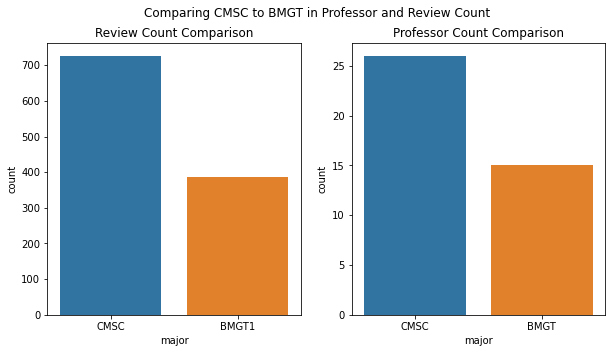

In [510]:
# Create DataFrames that contain the counts of each major's reviews and stats
stats_df = pd.DataFrame(columns=['major', 'count'])
stats_df['major'] = ['CMSC', 'BMGT']
stats_df['count'] = [len(all_cmsc_stats), len(all_bmgt_stats)]

reviews_df = pd.DataFrame(columns=['major', 'count'])
reviews_df['major'] = ['CMSC', 'BMGT1']
reviews_df['count'] = [len(all_cmsc_reviews), len(all_bmgt_reviews)]

# Plot them out to visually compare
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Comparing CMSC to BMGT in Professor and Review Count')
ax[0].set(title="Review Count Comparison")
ax[1].set(title="Professor Count Comparison")

sns.barplot(x='major', y='count', data=reviews_df, ax=ax[0])
sns.barplot(x='major', y='count', data=stats_df, ax=ax[1])

plt.show()

With these graphs we can see that CMSC has BMGT 'beat' in both the reviews and professors rated count department. The left graph shows that there are roughly double the amount of reviews for CMSC courses than there are for BMGT courses. Additionally, the right graph shows that roughly double the amount of CMSC professors have been reviewed than BMGT professors. Again, this data is aggregated from both PlanetTerp and RateMyProfessor. We have also queried for the same amount of courses.

We could infer this to mean that CMSC students are more likely to be posting reviews. It could also just mean that there are more CMSC students, and thus there are more reviews from them. Without exact numbers of the population of CMSC and BMGT students, it makes the comparison a little difficult. But it does give some insight into which major you're more likely to find reviews for the professor or course you want.

#### Look at Grade Dispersion for Each Major

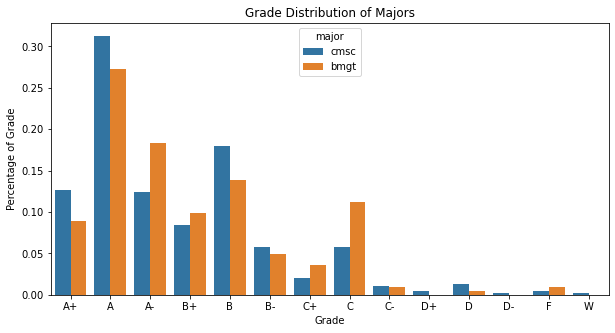

In [511]:
grades_df = pd.DataFrame()

# Get the grades from all the reviews, dropping reviews without a grade
grades_df = all_reviews[['major', 'expected_grade']].copy().dropna()

# Count how many of each grade per major
grades_df['count'] = 0
agg_grades_df = grades_df.groupby(['major', 'expected_grade']).count().reset_index()

# How many grades total do we have from each major
total_bmgt_grades = agg_grades_df.loc[agg_grades_df['major'] == 'bmgt']['count'].sum()
total_cmsc_grades = agg_grades_df.loc[agg_grades_df['major'] == 'cmsc']['count'].sum()

# Separate out the DataFrame so that it'll be easier to update values
bmgt_grades_df = agg_grades_df.loc[agg_grades_df['major'] == 'bmgt'].copy()
cmsc_grades_df = agg_grades_df.loc[agg_grades_df['major'] == 'cmsc'].copy()

cmsc_grades_df.update(cmsc_grades_df['count'].divide(total_cmsc_grades))
bmgt_grades_df.update(bmgt_grades_df['count'].divide(total_bmgt_grades))

# Bring them back together with the percentage values
agg_grades_df = pd.concat([cmsc_grades_df, bmgt_grades_df])

# Plot out the grade dispersion per major
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(ax=ax, data=agg_grades_df, x='expected_grade', y='count', hue='major', order=grades_list)

ax.set(title="Grade Distribution of Majors", xlabel="Grade", ylabel="Percentage of Grade")
print()

Here we've plotted the percentage of grades per major. Due to the unequal amount of CMSC and BMGT reviews, we can't simply compare the counts of each grade per major. Instead we use the percentage of each grade per major, to be more representative. We see that the majority of grades for both majors are typically within the A+ to B range. BMGT does appear to have double the amount of C grades than CMSC.

Again, this data does need to be taken with a grain of salt. It's likely we have [missing data not at random](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random) because students may not post reviews with poor grades. This grade data is strictly from scraped reviews with a reported grade in the range A+ to W. We'd also like to note that we have removed the reported grades of 'Other' or 'Rather not say.'

### Reviews and Data in Relation to Time

#### Utilities

In [534]:
# Fall start ~August 20 and after
fall_start = datetime.datetime(year=2020, month=8, day=20)
# Winter start ~January 2nd
winter_start = datetime.datetime(year=2020, month=1, day=2)
# Spring start ~January 20th
spring_start = datetime.datetime(year=2020, month=1, day=20)
# Summer start ~June 1st
summer_start = datetime.datetime(year=2020, month=6, day=1)

# We want to establish semester as a category, and to enforce an order
semester_list = ['Spring', 'Summer', 'Fall', 'Winter']
semester_type = CategoricalDtype(categories=semester_list, ordered=True)

def get_semester_from_unix(timestamp):
    """Determines what semester a review was posted - note, this is a rough
    estimate. Also note, it may be students post after their semester is over 
    and the next has started.
    
    Args:
        timestamp: A unix timestamp as an integer
    
    Returns:
        A string containing the respective semester to timestamp.
    """
    
    review_date = datetime.datetime.utcfromtimestamp(timestamp)
    review_year = review_date.year
    
    if review_date.month >= fall_start.month:
        return 'Fall'
    elif review_date.month >= summer_start.month:
        return 'Summer'
    elif review_date.month >= spring_start.month or  \
    (review_date.month == spring_start.month and review_date.day >= spring_start.day):
        return 'Spring'
    else:
        return 'Winter'
    
    return None


def get_month_from_unix(timestamp):
    """Determines the month from a given unix timestamp."""
    
    date = datetime.datetime.utcfromtimestamp(timestamp)
    return date.strftime('%B')


def get_year_from_unix(timestamp):
    """Determines the year from a given unix timestamp."""
    
    date = datetime.datetime.utcfromtimestamp(timestamp)
    return date.year

#### Look at Grade Dispersion Over Time

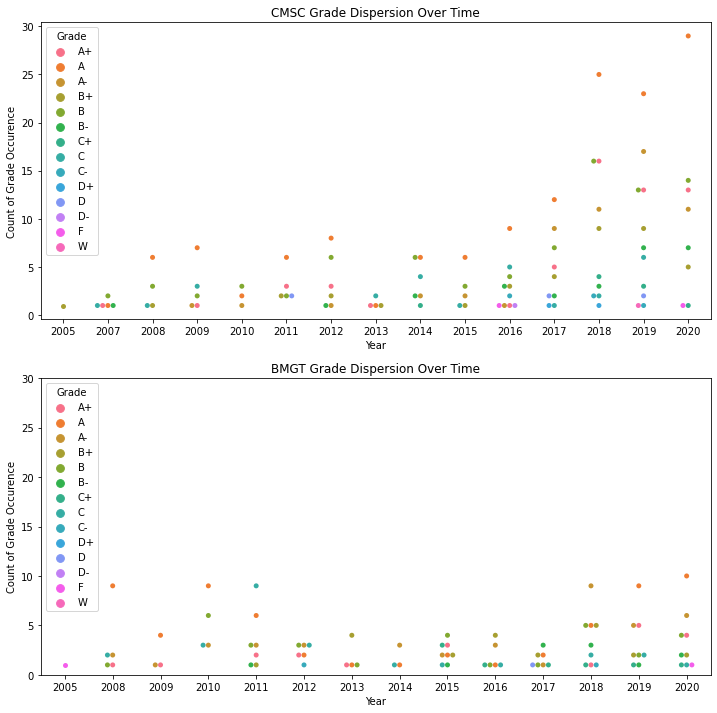

In [516]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
grade_type = CategoricalDtype(categories=grades_list, ordered=True)

# Get the CMSC grades and find the year of each review
cmsc_review_time = all_cmsc_reviews[['expected_grade', 'date', 'rating']].copy()
cmsc_review_time['year'] = cmsc_review_time['date'].apply(lambda date: get_year_from_unix(date))

# Get the amount of grades per grade per year
cmsc_review_year = cmsc_review_time.groupby(['year', 'expected_grade']).size().reset_index(name='count')
cmsc_review_year.rename(columns={'expected_grade': 'Grade'}, inplace=True)

# Want to use a category for the grade to keep it ordered
cmsc_review_year['Grade'] = cmsc_review_year['Grade'].astype(grade_type)

# Plot the CMSC grades over time
sns.swarmplot(data=cmsc_review_year, x='year', y='count', hue='Grade', palette=sns.color_palette('husl', n_colors=14), ax=ax[0])
ax[0].set(title="CMSC Grade Dispersion Over Time", ylabel='Count of Grade Occurence', xlabel='Year')
handles, labels = ax[0].get_legend_handles_labels()


# Get the BMGT grades and find the year of each review
bmgt_review_time = all_bmgt_reviews[['expected_grade', 'date', 'rating']].copy()
bmgt_review_time['year'] = bmgt_review_time['date'].apply(lambda date: get_year_from_unix(date))

# Get the amount of grades per grade per year
bmgt_review_year = bmgt_review_time.groupby(['year', 'expected_grade']).size().reset_index(name='count')
bmgt_review_year.rename(columns={'expected_grade': 'Grade'}, inplace=True)

# Want to use a category for the grade to keep it ordered
bmgt_review_year['Grade'] = bmgt_review_year['Grade'].astype(grade_type)

# Plot the BMGT grades over time
sns.swarmplot(data=bmgt_review_year, x='year', y='count', hue='Grade', palette=sns.color_palette('husl', n_colors=14), ax=ax[1])
ax[1].set(title="BMGT Grade Dispersion Over Time", ylabel='Count of Grade Occurence', xlabel='Year')
ax[1].set_ylim([0, 30])
print()

These graphs depict the grade count of majors over the years, as reported from RateMyProfessor and PlanetTerp. Interestingly, for most years, A seems to be the most frequent grade for CMSC student reviews. This does not hold for the BMGT major, where A drops to lower reported counts between 2011 and 2018. We should also point out that these graphs on the same scale, but as stated earlier, CMSC does have more reviews and reported grades. But from the data, it appears that CMSC reports better grades in the A range. However, we also see a larger gap between the grade frequency in CMSC, especially evident in 2018 through 2020. Overall, A count seems to have an increasing trend in CMSC, while such a trend is not present in BMGT and it remains mostly steady.

#### Look at Review Dispersion Over Time

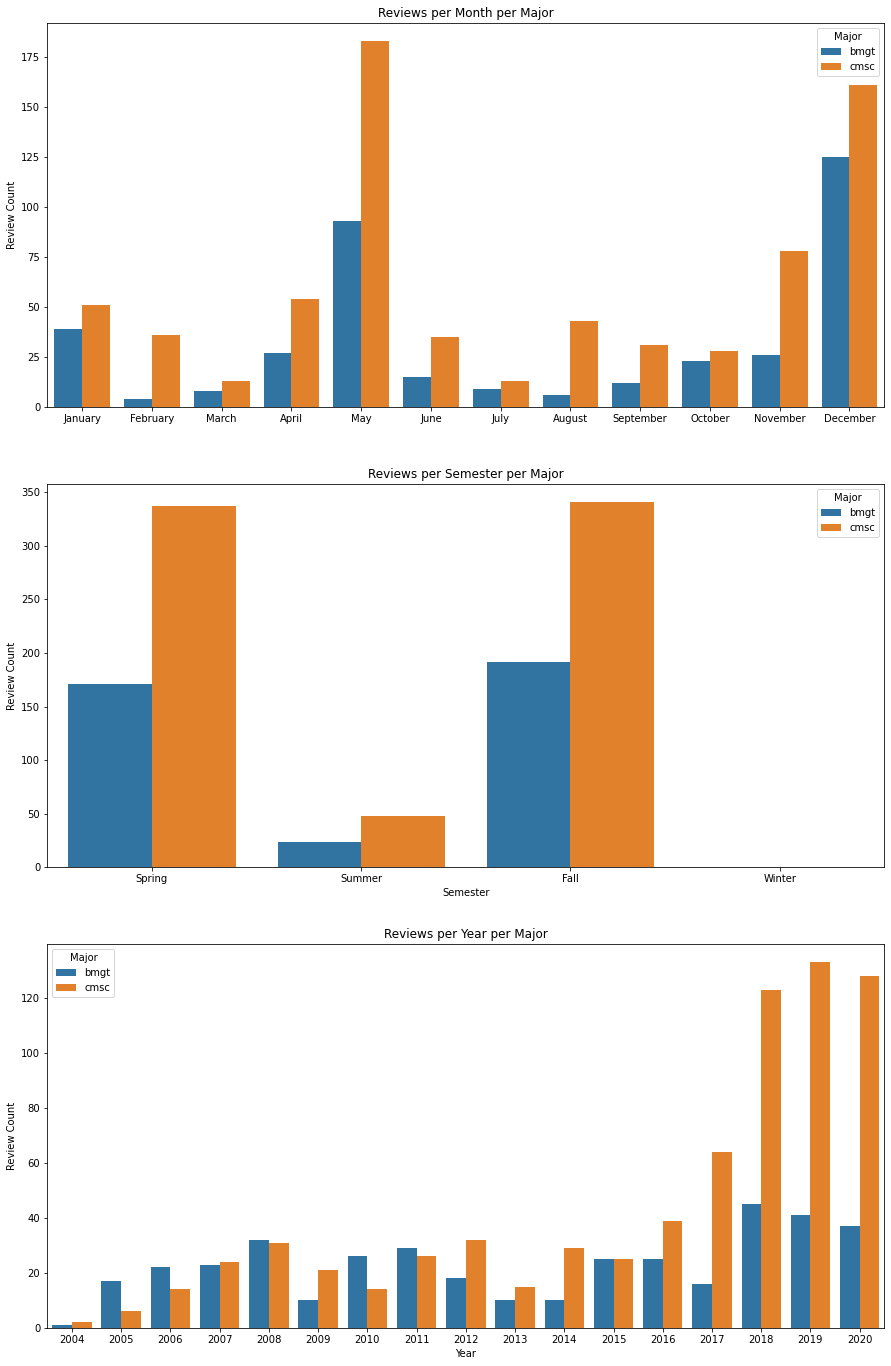

In [536]:
# Create a month category for dataframes
months = [calendar.month_name[i] for i in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)


# Grab the pertinent columns and get the month, year, and semester for each date
review_time_df = all_reviews[['date', 'major', 'source', 'rating']].copy().dropna()
review_time_df['month'] = review_time_df['date'].apply(lambda date: get_month_from_unix(date))
review_time_df['year'] = review_time_df['date'].apply(lambda date: get_year_from_unix(date))

# Need to make month categorical to make it ordered in the graph
review_time_df['month'] = review_time_df['month'].astype(month_type)

# Need to make semester categorical to make it ordered in the graph
review_time_df['semester'] = review_time_df['date'].apply(lambda date: get_semester_from_unix(date))
review_time_df['semester'] = review_time_df['semester'].astype(semester_type)

fig, ax = plt.subplots(3, 1, figsize=(15, 24))

# Reviews per month per major
review_month_major = review_time_df.groupby(['month', 'major']).size().reset_index(name='count')
sns.barplot(ax=ax[0], data=review_month_major, x='month', y='count', hue='major')
ax[0].set(title="Reviews per Month per Major", xlabel='', ylabel='Review Count')
ax[0].legend(title='Major')

# Review per semester per major
review_semester_major = review_time_df.groupby(['semester', 'major']).size().reset_index(name='count')
sns.barplot(ax=ax[1], data=review_semester_major, x='semester', y='count', hue='major')
ax[1].set(title="Reviews per Semester per Major", xlabel='Semester', ylabel='Review Count')
ax[1].legend(title='Major')

# Reviews per year per major
review_year_major = review_time_df.groupby(['year', 'major']).size().reset_index(name='count')
sns.barplot(ax=ax[2], data=review_year_major, x='year', y='count', hue='major')
ax[2].set(title="Reviews per Year per Major", xlabel='Year', ylabel='Review Count')
ax[2].legend(title='Major')

print()

With these graphs we can see the dispersion of reviews over time. The first graph is by month, regardless of the year. We see most reviews seem to be posted in December and May, for both majors. May marks the end of the the Spring semester and December marks the end of the Fall semester, so this is not all too surprising. This lines up roughly with the reviews posted per semester, as seen in the second graph. Not all too surprising, but no reviews were posted in the short amount of time that is the Winter semester (January 1st start date to roughly January 20th). Thus, the first two graphs definitely have a bimodal distribution. Lastly, we show the amount of reviews posted per yer in the last graph. We see an increasing trend over the years for CMSC reviews posted, although BMGT reviews tend to have little variation. These last 2-3 years for CMSC has certainly seen a boom in reviews.

#### Look at Review Rating Over Time

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(25, 15))

# Get the median rating of all professors in a major
med_cmsc_prof_rating = all_cmsc_stats['avg_rating'].median()
med_bmgt_prof_rating = all_bmgt_stats['avg_rating'].median()
avg_cmsc_prof_rating = all_cmsc_stats['avg_rating'].mean()
avg_bmgt_prof_rating = all_bmgt_stats['avg_rating'].mean()

# Group CMSC by the year and rating to see dispersion over the years
cmsc_rating_time = cmsc_review_time.copy()
cmsc_rating_time = cmsc_rating_time.groupby(['year', 'rating']).size().reset_index(name='count')
sns.boxplot(data=cmsc_rating_time, x='year', y='rating', ax=ax[0])

ax[0].axhline(y=med_cmsc_prof_rating, linestyle='dashed', label='Median Prof. Rating')
ax[0].axhline(y=avg_cmsc_prof_rating, linestyle='solid', color='red', label='Mean Prof. Rating')
ax[0].set(title="CMSC Review Rating Dispersion Over Time", xlabel='Year', ylabel='Rating')
labels = ['Median Professor Rating', 'Mean Prof. Rating']
handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend(handles = handles[0:], labels=labels)

# Group BMGT reviews by the year and rating to see dispersion over the years
bmgt_rating_time = bmgt_review_time.copy()
bmgt_rating_time = bmgt_rating_time.groupby(['year', 'rating']).size().reset_index(name='count')
sns.boxplot(data=bmgt_rating_time, x='year', y='rating', ax=ax[1])

ax[1].axhline(y=med_bmgt_prof_rating, linestyle='dashed', label='Median Prof. Rating')
ax[1].axhline(y=avg_bmgt_prof_rating, linestyle='solid', color='red', label='Mean Prof. Rating')
ax[1].set(title="BMGT Review Rating Dispersion Over Time", xlabel='Year', ylabel='Rating')
labels = ['Median Professor Rating', 'Mean Prof. Rating']
handles, _ = ax[1].get_legend_handles_labels()
ax[1].legend(handles = handles[0:], labels=labels)
print()

These graphs depict the dispersion of ratings given to professors by students of each major over the years. While there is higher dispersion in the earlier years, such as from 2004 to 2013, we see it start to level out to around a rating 3.0 in both majors. Skewed dispersions, such as in 2004 in both graphs or 2009 and 2013 of BMGT can be explained by the low amount of reviews those years (as seen in the graph above). We've also plotted the average and median professor rating for each major. Due to their close similarity, there is likely no high amount of outliers skewing the data (though this can be interpreted from the boxplots as well). So, it appears both majors have arrived roughly at the same professor rating by 2020.

#### Reviews and Ratings By the Source

In [ ]:
fix, ax = plt.subplots(2, 1, figsize=(25, 24))

# Groups reviews by year and source
review_source = review_time_df.groupby(['year', 'source']).size().reset_index(name='count')
review_source.loc[review_source['source'] == 'rmp', 'full_source'] = 'RateMyProfessor'
review_source.loc[review_source['source'] == 'pt', 'full_source'] = 'PlanetTerp'

# Plots out this grouping distribution
sns.barplot(ax=ax[0], data=review_source, x='year', y='count', hue='full_source', palette=sns.color_palette('Set2'))
ax[0].set(title="Reviews per Year per Source", xlabel='Year', ylabel='Review Count')
ax[0].legend(title='Source')

# Groups years by their rating, source, and year to get a distribution of rating per source
rating_source = review_time_df[['source', 'year', 'rating']].copy()
rating_source.loc[rating_source['source'] == 'rmp', 'full_source'] = 'RateMyProfessor'
rating_source.loc[rating_source['source'] == 'pt', 'full_source'] = 'PlanetTerp'
rating_source = rating_source.groupby(['rating', 'year', 'full_source']).size().reset_index(name='count')

# Plots out this grouping
sns.boxplot(data=rating_source, x='year', y='rating', hue='full_source', ax=ax[1])
ax[1].set(title="Rating Distribution per Year per Source", xlabel='Year', ylabel='Rating Score')
ax[1].legend(title='Source')
print()

TODO: Explain graphs

### Analyzing Word Frequencies and Rudimentary Sentiment Analysis in Reviews

#### Using spaCy

We use [spaCy](https://spacy.io/) to process text. Here we are mainly using to first get the lemmas for each word in the review. The lemma is essentially the 'root' of a word - it normalizes the tense, plurality, etc. We also remove typical stop words in English, such as 'the' or 'a'. [More about lemmatization can be read about here.](https://en.wikipedia.org/wiki/Lemmatisation) 

We need to turn words into their lemma because word forms may vary across reviews, but are in essence the same. It also makes checking for words simpler, such that we don't need to check every word for every form of it. Additionally, the removal of stop words is to remove 'useless' data. There isn't much to learn from the use of words like 'the' in a sentence, so we just remove them.

In [ ]:
##  Need to run python -m spacy download en_core_web_sm (also a medium and large dataset)
nlp = spacy.load('en_core_web_sm')

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
punctuation = string.punctuation

In [ ]:
# Credit to https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
def tokenize_lemmatize_text(text):
    tokens = nlp(text)
    
    tokens = [word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in tokens]
    tokens = [lemma for lemma in tokens if lemma not in spacy_stopwords and lemma not in punctuation]
    
    return tokens

##### Bag of Words maybe for TF-IDF

#### Label the Reviews as Positive or Negative

TODO: Explain why we did it this way

#### Reading Positive and Negative Lexicons

In [ ]:
def save_word_dict(filepath, word_dict):
    """Saves word frequency dictionaries to a pickle file."""
    pickle.dump(word_dict, open(filepath, 'wb'))
    
    
def read_word_dict_file(filepath):
    """Reads a word frequency dictionary from a pickle file."""
    return pickle.load(open(filepath, 'rb'))


def read_lexicon(filepath):
    """Read a lexicon full of words from a file and insert them into
    a list to return. Simple \n separation.
    
    Args:
        filepath: A string containing the filepath to the lexicon.
        
    Returns:
        A list of words (one per line).
    """
    
    lexicon = []
    
    with open(filepath, 'r') as fp:
        all_words = fp.readlines()
        for word in all_words:
            lexicon.append(word.strip())
            
    return lexicon

In [ ]:
# Load positive words
positive_words = read_lexicon('./data/lexicon/positive-words.txt')
positive_words.append('funny')
positive_words.remove('tough')

# Load negative words
negative_words = read_lexicon('./data/lexicon/negative-words.txt')
negative_words.append('tough')
negative_words.remove('funny')

#### Functions for Scoring and Labeling the Sentiment of Reviews 

In [ ]:
def save_sentiment_score_labels(review_df, source, major):
    """Handles saving the sentiment scores to the correct database,
    depending on the major and source of the review.
    
    Args:
        review_df: Dataframe of reviews
        source: Source of the reviews to save ('pt', 'rmp')
        major: The major of the reviews to save ('bmgt', 'cmsc')
    """
    
    if not should_store_data:
        return
    
    if source == 'pt':
        if major == 'bmgt':
            db_filepath = bmgt_pt_db_filepath
        else:
            db_filepath = cmsc_pt_db_filepath
    else:
        if major == 'bmgt':
            db_filepath = bmgt_rmp_db_filepath
        else:
            db_filepath = cmsc_rmp_db_filepath
            
    db_conn = create_connection(db_filepath)
    
    try:
        insert_all_review_sentiment_labels(db_conn, review_df)
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
        
    finally:
        if db_conn:
            db_conn.close()
            
            
def update_word_dict(word_dict, word):
    """Updates a counting dictionary depending on if key is present."""
    if word not in word_dict:
        word_dict[word] = 1
    else:
        word_dict[word] = word_dict[word] + 1
        
    return word_dict


def normalize_score(score, max_score, min_score):
    """Normalizes the score to [-1, 1] range."""
    denom = (max_score - min_score)
    
    if denom == 0:
        return np.nan
    
    norm_score = 2 * ((score - min_score) / denom) - 1
    
    return norm_score


def get_label_from_score(score):
    """Returns a label for a score, where 1 is positive,
    0 is neutral, and -1 is negative."""
    
    if score > 0:
        return 1
    elif score < 0:
        return -1
    
    return score
    
    
def score_review(review_body, positive_dict, negative_dict, all_word_dict):
    """A rudimentary sentiment scoring algorithm, which subtracts from the
    score when a negative word is present and adds to the score when a 
    positive word is present. No POS is used. Words are lemmatized.
    
    Args:
        review_body: A string containing the body of the review.
        
    Returns:
        An integer score
    """
    
    score = 0
    tokens = tokenize_lemmatize_text(review_body)
    
    for token in tokens:
        all_word_dict = update_word_dict(all_word_dict, token)
        
        if token in positive_words:
            positive_dict = update_word_dict(positive_dict, token)
            score = score + 1
        
        elif token in negative_words:
            negative_dict = update_word_dict(negative_dict, token)
            score = score - 1
            
    return (score, positive_dict, negative_dict, all_word_dict)


def score_all_reviews(review_df):
    """Scores each review as in range [-1, 1], and also keeps
    track of the frequencies of words for all, positive, and negative words.
    
    Args:
        review_df: A dataframe containing reviews.
        
    Returns:
        A tuple of an updates review dataframe with scores, a positive word frequency dictionary,
        a negative word frequency dictionary, and all word dictionary frequency.
    """
    
    scores = []
    positive_dict = {}
    negative_dict = {}
    all_word_dict = {}
    
    for row in review_df.itertuples():
        (score, positive_dict, negative_dict, all_word_dict) = score_review(row.body, positive_dict, negative_dict, all_word_dict)
        scores.append(score)
        
    # TODO: Normalize scores if we want a range of positive/negativeness?
    max_score = max(scores)
    min_score = min(scores)
    norm_scores = [normalize_score(score, max_score, min_score) for score in scores]
    
    # Label the reviews
    labels = [get_label_from_score(score) for score in scores]
    
    review_df['sentiment_score'] = scores
    review_df['sentiment_ground_label'] = labels
    
    return (review_df, positive_dict, negative_dict, all_word_dict)


def reviews_need_sentiment(sentiment_df):
    """If the ground labels are full of empty strings or null values, then
    the reviews have not been scored and labeled yet.
    
    Args:
        sentiment_df: A dataframe holding reviews
    
    Returns:
        True if there are no sentiment ground labels, false otherwise.
    """
    
    empty_sentiment_labels = (sentiment_df['sentiment_ground_label'].values == '').sum()
    null_sentiment_labels = sentiment_df['sentiment_ground_label'].isnull().sum()
    
    return null_sentiment_labels != 0 or empty_sentiment_labels != 0
    
    
def score_and_label_reviews(sentiment_df, major, dict_fp):
    """Scores and labels the provided reviews from the sentiment DataFrame, storing them
    into a database, along with gathering word frequency dictionaries.
    
    Args:
        sentiment_df: A dataframe holding reviews
        major: A string containing the major name ('cmsc', 'bmgt')
        dict_fp: A string holding the start of the filepath to the dictionaries
        
    Returns:
        A tuple of an updated sentiment dataframe with scores and labels, along with
        the word frequency dictionaries - (df, positive, negative, all)
    """
    
    (sentiment_df, positive_dict, negative_dict, all_word_dict) = score_all_reviews(sentiment_df)

    pt_reviews = sentiment_df.loc[sentiment_df['source'] == 'pt']
    save_sentiment_score_labels(pt_reviews, 'pt', major)

    rmp_reviews = sentiment_df.loc[sentiment_df['source'] == 'rmp']
    save_sentiment_score_labels(rmp_reviews, 'rmp', major)

    save_word_dict(dict_fp + 'positive.p', positive_dict)
    save_word_dict(dict_fp + 'negative.p', negative_dict)
    save_word_dict(dict_fp + 'all.p', all_word_dict)
    
    return (sentiment_df, positive_dict, negative_dict, all_word_dict)
    
    
def read_word_freq_dicts(dict_fp):
    """Reads the positive, negative, and all word word frequency
    dictionaries and returns them in this order as a tuple."""
    
    positive_dict = read_word_dict_file(dict_fp + 'positive.p')
    negative_dict = read_word_dict_file(dict_fp + 'negative.p')
    all_word_dict = read_word_dict_file(dict_fp + 'all.p')
    
    return (positive_dict, negative_dict, all_word_dict)

#### Score and Label CMSC Reviews

In [ ]:
cmsc_dict_fp = './data/word_lists/cmsc_'
cmsc_sentiment_df = all_cmsc_reviews.copy()

# If the reviews don't have sentiment scoring/label, then do so
if reviews_need_sentiment(cmsc_sentiment_df):
    (cmsc_sentiment_df, 
     cmsc_positive_dict, 
     cmsc_negative_dict, 
     cmsc_all_word_dict) = score_and_label_reviews(cmsc_sentiment_df, 'cmsc', cmsc_dict_fp)
    
# Otherwise, just read in the word frequency dictionaries
else:
    (cmsc_positive_dict, 
     cmsc_negative_dict, 
     cmsc_all_word_dict) = read_word_freq_dicts(cmsc_dict_fp)

cmsc_sentiment_df.head()

#### Score and Label BMGT Reviews

In [ ]:
bmgt_dict_fp = './data/word_lists/bmgt_'
bmgt_sentiment_df = all_bmgt_reviews.copy()

# If the reviews don't have sentiment scoring/label, then do so
if reviews_need_sentiment(bmgt_sentiment_df):
    (bmgt_sentiment_df, 
     bmgt_positive_dict, 
     bmgt_negative_dict,
     bmgt_all_word_dict) = score_and_label_reviews(bmgt_sentiment_df, 'bmgt', bmgt_dict_fp)
    
# Otherwise, just read in the word frequency dictionaries
else:
    (bmgt_positive_dict,
     bmgt_negative_dict,
     bmgt_all_word_dict) = read_word_freq_dicts(bmgt_dict_fp)
    
bmgt_sentiment_df.head()

#### Looking at how often these types of words are used per major

In [ ]:
# Get the percentage of each type of word type per major
cmsc_all_word_count = sum(cmsc_all_word_dict.values())
cmsc_positive_pct = sum(cmsc_positive_dict.values()) / cmsc_all_word_count
cmsc_negative_pct = sum(cmsc_negative_dict.values()) / cmsc_all_word_count

bmgt_all_word_count = sum(bmgt_all_word_dict.values())
bmgt_positive_pct = sum(bmgt_positive_dict.values()) / bmgt_all_word_count
bmgt_negative_pct = sum(bmgt_negative_dict.values()) / bmgt_all_word_count

# Put these percentages into a dataframe
word_pct_df = pd.DataFrame(columns=['type', 'major', 'percentage'])

word_pct_df = word_pct_df.append({'type': 'positive' , 'major': 'bmgt', 'percentage': bmgt_positive_pct}, ignore_index=True)
word_pct_df = word_pct_df.append({'type': 'negative' , 'major': 'bmgt', 'percentage': bmgt_negative_pct}, ignore_index=True)

word_pct_df = word_pct_df.append({'type': 'positive' , 'major': 'cmsc', 'percentage': cmsc_positive_pct}, ignore_index=True)
word_pct_df = word_pct_df.append({'type': 'negative' , 'major': 'cmsc', 'percentage': cmsc_negative_pct}, ignore_index=True)

# Display the dataframe as a bar graph
ax = sns.catplot(x='type', y='percentage', kind='bar', hue='major', data=word_pct_df)
ax.set(xlabel='Type of words', ylabel='Perctange of all words', title='Percentage of types of words per major')

TODO: Explain graphs

#### Sentiment Dispersion and Trends

TODO: Explain graphs

## [Applying Machine Learning](#Applying-Machine-Learning)

TODO: Fill in section

### Natural Language Processig - Predicting Sentiment

### Predicting Trends Over Time

## Visualization

TODO: Describe section

### Visualizing Word Associations and Sentiments

In [ ]:
def create_wordcloud(word_freq_dict):
    """Creates a single WordCloud given the word frequency dictionary.
    
    Args:
        word_freq_dict: A dictionary of word frequencies.
        
    Returns:
        A WordCloud object created from the provided dictionary.
    """
    
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate_from_frequencies(word_freq_dict)
    
    return wc
    
    
def plot_multiple_wordclouds(titles, word_freq_dicts):
    """Creates a wordcloud for each word frequency dictionary into a 
    3 x 1 subplot figure. Titles must be the same length as the dictionaries.
    
    Args:
        titles: Title of each plot/word cloud.
        word_freq_dicts: List of word frequency dictionaries.
    """
    
    figure, ax = plt.subplots(1, 3, figsize=(30, 10))
    
    for idx in range(len(word_freq_dicts)):
        ax[idx].imshow(create_wordcloud(word_freq_dicts[idx]))
        ax[idx].axis('off')
        ax[idx].set_title(titles[idx], fontdict={'fontsize': 23})
            
    plt.show()

In [ ]:
plot_multiple_wordclouds(['Positive', 'Negative', 'All'], [cmsc_positive_dict, cmsc_negative_dict, cmsc_all_word_dict])

In [ ]:
plot_multiple_wordclouds(['Positive', 'Negative', 'All'], [bmgt_positive_dict, bmgt_negative_dict, bmgt_all_word_dict])

### Visualizing Review Trends and Trends Over Time

## [Insights and Conclusion](#Insights-and-Conclusion)

It is worthy to consider possible sources of bias inside our data set. One bias at play is self-selection bias -- the bias that people who have had negative experiences are more likely to respond on surveys or polls. In the case of RateMyProfessor, this is almost certainly influential -- students who received their first bad grade, or first conflict with a professor, are more likely to express and vent their frustration than students who have had relatively plain or positive experiences. Furthermore, the aggregate of all reviews from each major yielded about 2x more CS students than BMGT students (726 CS to 387 BMGT) -- for one reason or another, CS students are more represented on these online websites (participation bias). Although we normalized for these (accounting for percentages of reviews positive/negative, rather than total counts), the sample size may not be perfectly representative of the population as a whole. 

In [ ]:
#Example of Self-Selection Bias
Image("img/angry_review.png")

## [Potential Future Work](#Potential-Future-Work)

Future research can be divided into two categories, (1) improving the accuracy, models, and analysis of this current work, or (2) expanding the scope of the research, seeking to answer broader questions.

Improvements could seek to gage how representative the PlanetTerp reviews are, by comparing them to the actual course data recorded by UMD (although this would require special permissions to access data about course grade distributions in the past). Furthermore, improvements to the NLP model can be made -- our training data set was rudimentary in its generation, by simply counting positive/negative word frequencies -- a deeper, more accurate model could increase overall accuracy and validity of our training data before it enters the Machine Learning phase. 

Ideas for expansion could consider more majors at UMD, and seek to answer questions about more general trends -- how do STEM majors compare in course reviews to those of Humanities subjects? Which professors are the "most likable" in all of UMD? Eventually, once the models are good enough, they can even be extracted to consider other Universities with comparatively little extra work -- just employ the same models on similar websites (RateMyProfessor techniques and models can be recycled, as the website stores data for most universities). How do the mean grades of introductory CS classes at UMD compare to those of CS classes at UC Berkeley? Are CS students overrepresented at those campuses as well? 

[Back to Top](#Table-of-Contents)